In [16]:
SAVED_MODEL_DIGIT_FILENAME = "saved_model_digit"
SAVED_MODEL_FIGURE_FILENAME = "saved_model_figure"
SAVED_MODEL_ALPHABET_FILENAME = "saved_model_alphabet"
FLOAT_TFL_MODEL_DIGIT_FILENAME = "float_model_digit.tfl"
FLOAT_TFL_MODEL_FIGURE_FILENAME = "float_model_figure.tfl"
FLOAT_TFL_MODEL_ALPHABET_FILENAME = "float_model_alphabet.tfl"
QUANTIZED_TFL_MODEL_DIGIT_FILENAME = "quantized_model_digit.tfl"
QUANTIZED_TFL_MODEL_FIGURE_FILENAME = "quantized_model_figure.tfl"
QUANTIZED_TFL_MODEL_ALPHABET_FILENAME = "quantized_model_alphabet.tfl"
TFL_CC_MODEL_DIGIT_FILENAME = "magic_wand_model_digit_data.cc"
TFL_CC_MODEL_FIGURE_FILENAME = "magic_wand_model_figure_data.cc"
TFL_CC_MODEL_ALPHABET_FILENAME = "magic_wand_model_alphabet_data.cc"

In [17]:
!curl -L https://github.com/Jisu0917/magic_wand_all/archive/25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9.zip -o magic_wand_data.zip
!unzip -n magic_wand_data.zip
!rm -rf magic_wand_data_alphabets
!rm -rf magic_wand_data_digits
!rm -rf magic_wand_data_figures
!mkdir -p magic_wand_data_alphabets
!mkdir -p magic_wand_data_digits
!mkdir -p magic_wand_data_figures
!mv -f magic_wand_all-*/alphabet_* magic_wand_data_alphabets
!mv -f magic_wand_all-*/digit_* magic_wand_data_digits
!mv -f magic_wand_all-*/figure_* magic_wand_data_figures
!rm -rf magic_wand_all-*
!rm -rf magic_wand_data.zip
!rm -rf sample_data
!mkdir -p checkpoints

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  871k    0  871k    0     0  1547k      0 --:--:-- --:--:-- --:--:-- 1547k
Archive:  magic_wand_data.zip
25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9
   creating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_a.json  
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_b.json  
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_c.json  
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_d.json  
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_e.json  
  inflating: magic_wand_all-25e6d0c58c3d3767182ff441fa3dd2c7c67d09a9/alphabet_f.json  
  inflating: magic_wa

In [18]:
# alphabet 데이터 스트로크 생성
import glob
import json

strokes_alphabet = []
for filename in glob.glob("magic_wand_data_alphabets/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_alphabet.append(stroke)

In [19]:
# digit 데이터 스트로크 생성
import glob
import json

strokes_digit = []
for filename in glob.glob("magic_wand_data_digits/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_digit.append(stroke)

In [20]:
# figure 데이터 스트로크 생성
import glob
import json

strokes_figure = []
for filename in glob.glob("magic_wand_data_figures/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_figure.append(stroke)

In [21]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

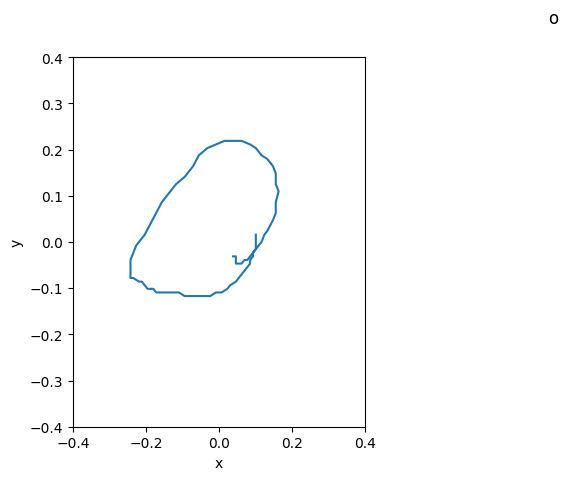

In [22]:
plot_stroke(strokes_alphabet[11])

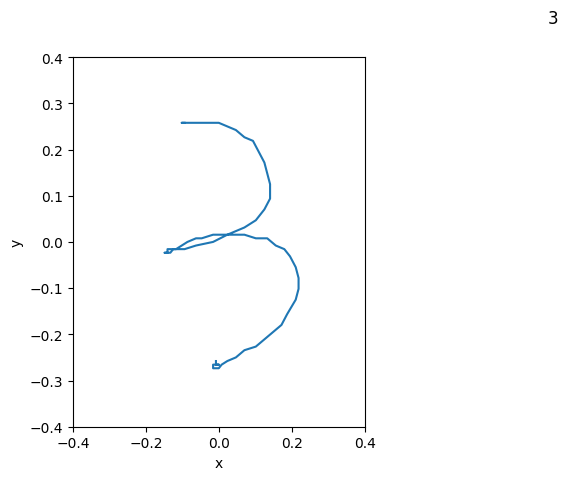

In [23]:
plot_stroke(strokes_digit[11])

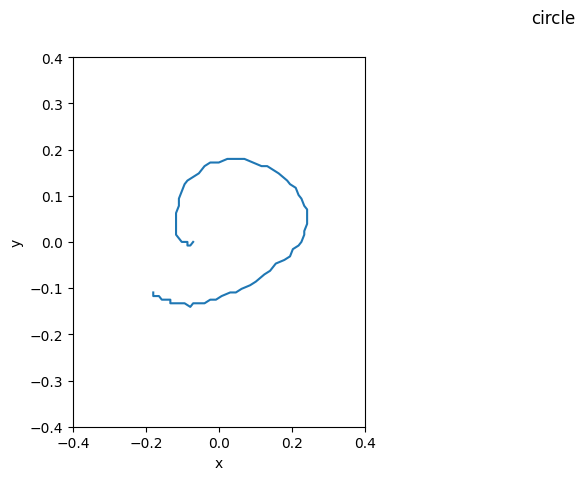

In [24]:
plot_stroke(strokes_figure[11])

In [25]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

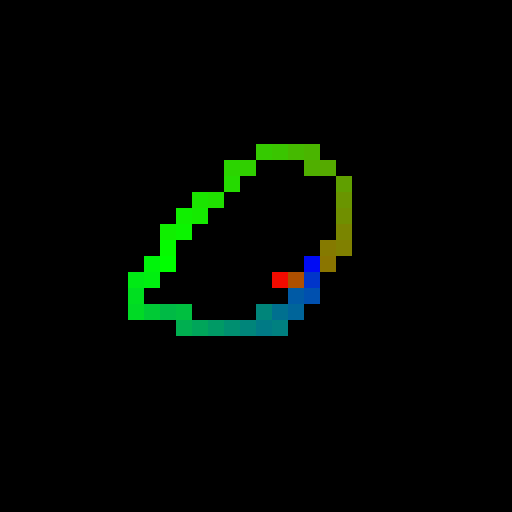

In [26]:
raster = rasterize_stroke(strokes_alphabet[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

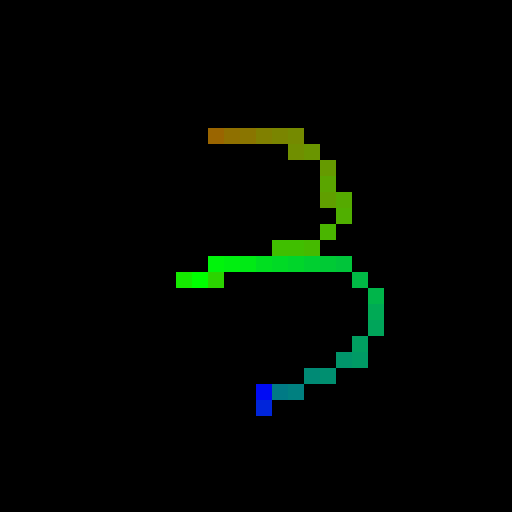

In [27]:
raster = rasterize_stroke(strokes_digit[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

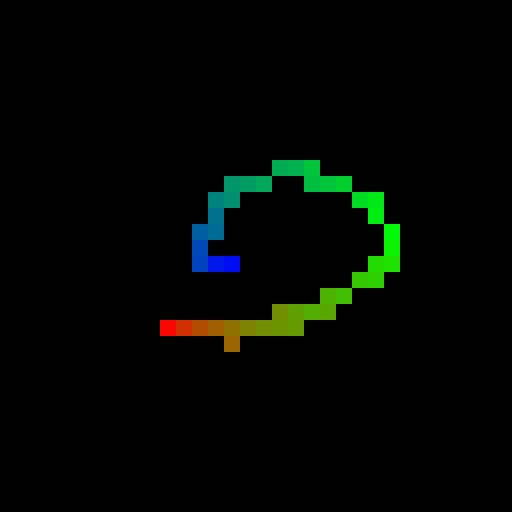

In [28]:
raster = rasterize_stroke(strokes_figure[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [29]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [30]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# alphabet 데이터 이미지 생성

shuffled_strokes = strokes_alphabet
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [31]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# digit 데이터 이미지 생성

shuffled_strokes = strokes_digit
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [32]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# figure 데이터 이미지 생성

shuffled_strokes = strokes_figure
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory

# 알파벳
validation_ds_alphabet = image_dataset_from_directory(
    directory='validation_alphabet',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_alphabet = image_dataset_from_directory(
    directory='train_alphabet',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

# 숫자
validation_ds_digit = image_dataset_from_directory(
    directory='validation_digit',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_digit = image_dataset_from_directory(
    directory='train_digit',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

# 도형
validation_ds_figure = image_dataset_from_directory(
    directory='validation_figure',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_figure = image_dataset_from_directory(
    directory='train_figure',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 208 files belonging to 26 classes.
Found 18304 files belonging to 26 classes.
Found 100 files belonging to 10 classes.
Found 8800 files belonging to 10 classes.
Found 15 files belonging to 3 classes.
Found 1419 files belonging to 3 classes.


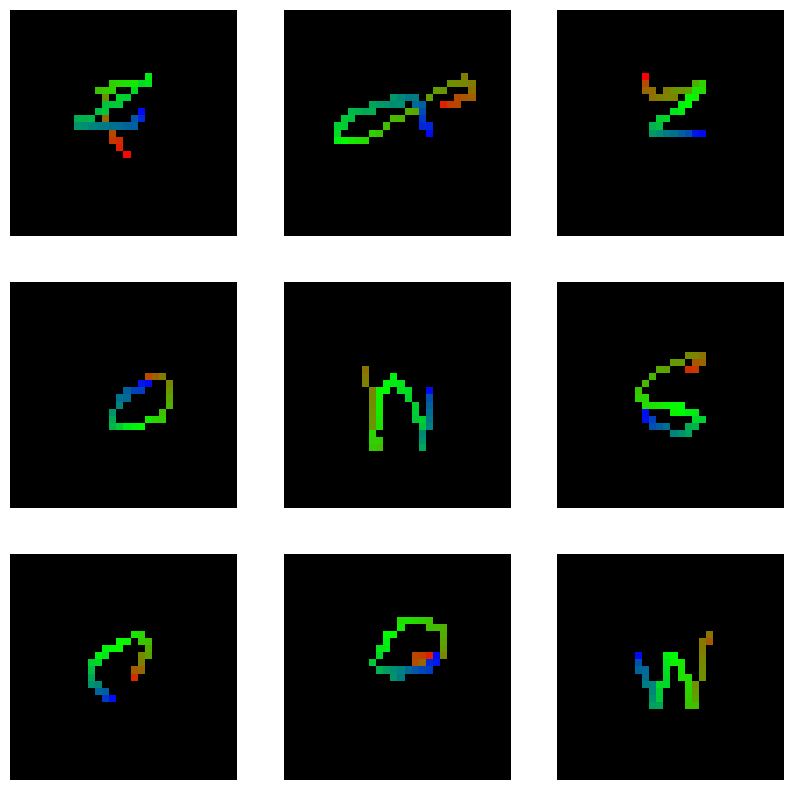

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_alphabet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

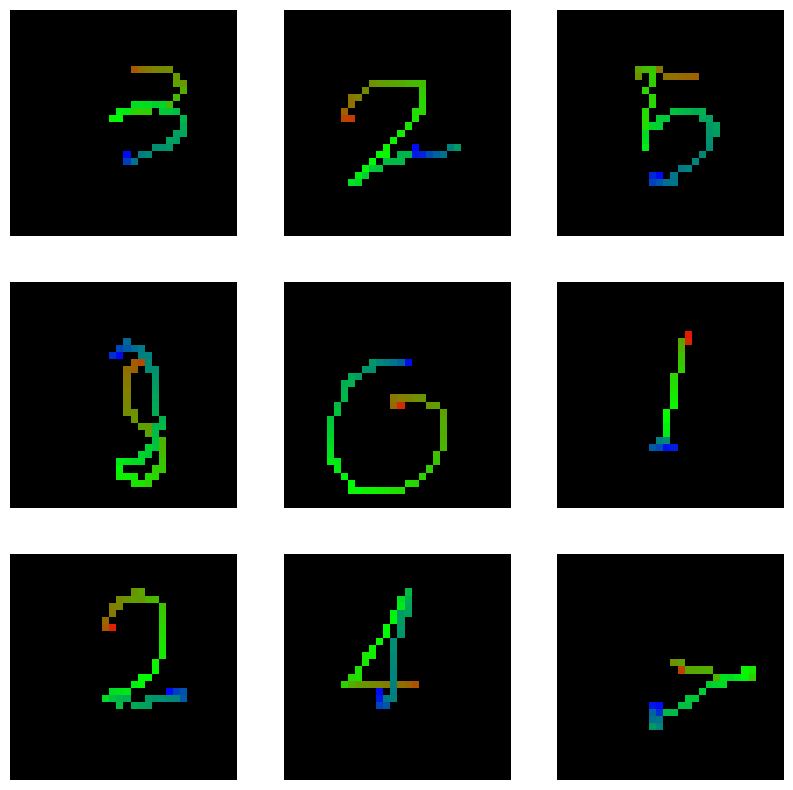

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_digit.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

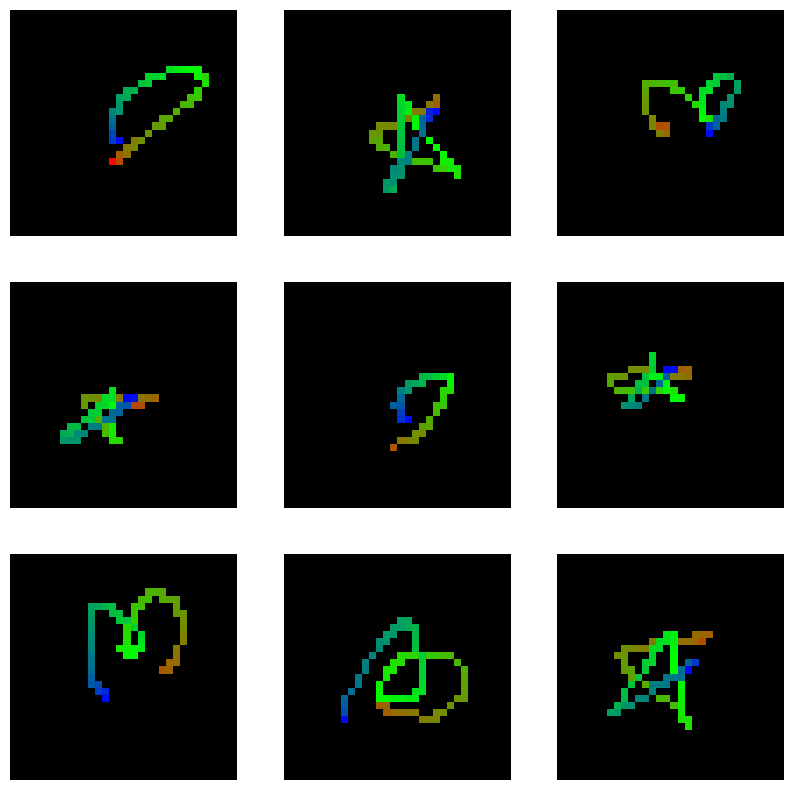

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_figure.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [37]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

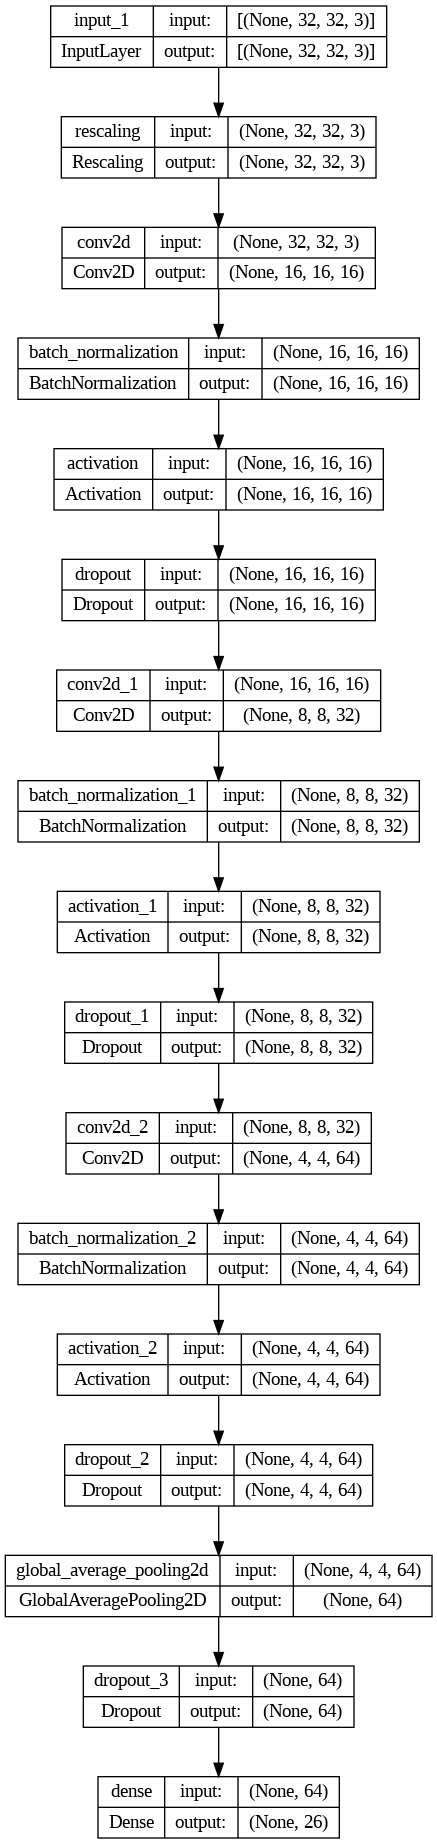

In [38]:
model_alphabet = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=26)
keras.utils.plot_model(model_alphabet, show_shapes=True)

In [39]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_alphabet_at_{epoch}.h5"),
]
model_alphabet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_alphabet.fit(
    train_ds_alphabet, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_alphabet,
)

Epoch 1/30
572/572 [==============================] - 12s 9ms/step - loss: 0.2120 - accuracy: 0.0526 - val_loss: 0.1595 - val_accuracy: 0.1058


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
572/572 [==============================] - 7s 12ms/step - loss: 0.1643 - accuracy: 0.0834 - val_loss: 0.1504 - val_accuracy: 0.1827
Epoch 3/30
572/572 [==============================] - 5s 9ms/step - loss: 0.1590 - accuracy: 0.1018 - val_loss: 0.1452 - val_accuracy: 0.2548
Epoch 4/30
572/572 [==============================] - 5s 8ms/step - loss: 0.1551 - accuracy: 0.1234 - val_loss: 0.1404 - val_accuracy: 0.3077
Epoch 5/30
572/572 [==============================] - 5s 8ms/step - loss: 0.1508 - accuracy: 0.1505 - val_loss: 0.1335 - val_accuracy: 0.3317
Epoch 6/30
572/572 [==============================] - 6s 10ms/step - loss: 0.1460 - accuracy: 0.1781 - val_loss: 0.1272 - val_accuracy: 0.3558
Epoch 7/30
572/572 [==============================] - 4s 8ms/step - loss: 0.1416 - accuracy: 0.2088 - val_loss: 0.1222 - val_accuracy: 0.3798
Epoch 8/30
572/572 [==============================] - 4s 8ms/step - loss: 0.1381 - accuracy: 0.2331 - val_loss: 0.1168 - val_accuracy: 0.4567
Epoc

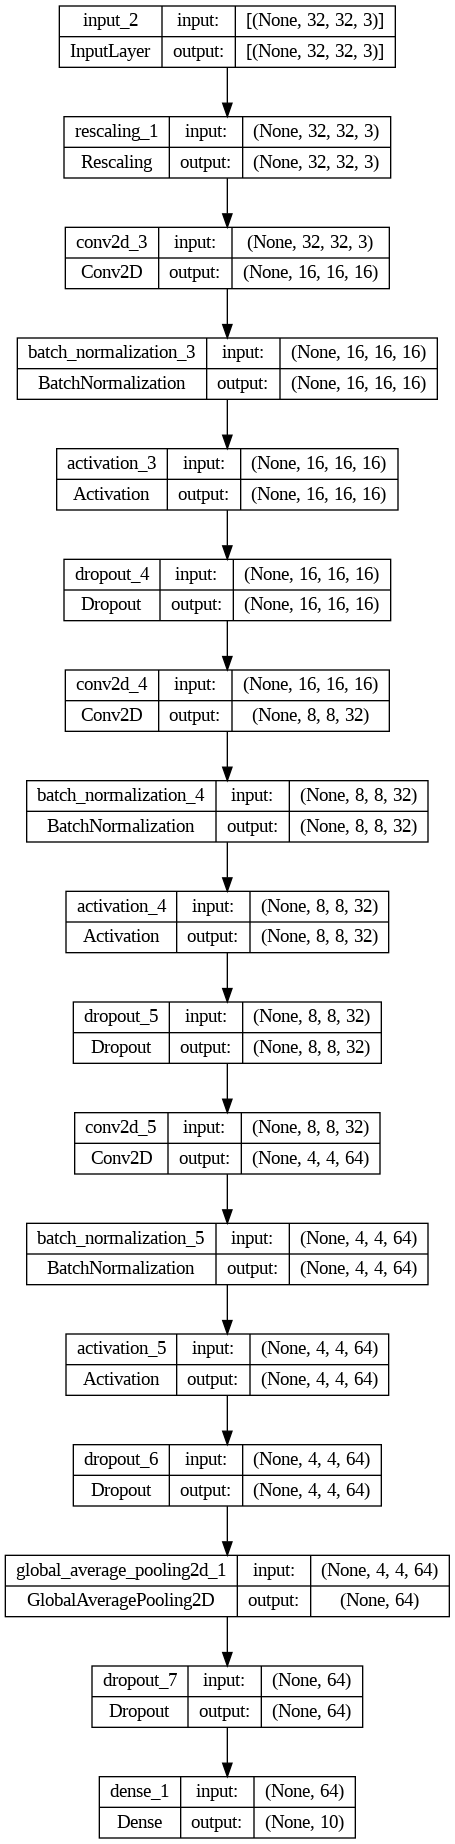

In [40]:
model_digit = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=10)
keras.utils.plot_model(model_digit, show_shapes=True)

In [41]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_digit_at_{epoch}.h5"),
]
model_digit.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_digit.fit(
    train_ds_digit, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_digit,
)

Epoch 1/30
275/275 [==============================] - 6s 12ms/step - loss: 0.3785 - accuracy: 0.1440 - val_loss: 0.3580 - val_accuracy: 0.1100
Epoch 2/30
275/275 [==============================] - 2s 8ms/step - loss: 0.3107 - accuracy: 0.2339 - val_loss: 0.3016 - val_accuracy: 0.2100
Epoch 3/30
275/275 [==============================] - 2s 8ms/step - loss: 0.2935 - accuracy: 0.2985 - val_loss: 0.2495 - val_accuracy: 0.6000
Epoch 4/30
275/275 [==============================] - 2s 8ms/step - loss: 0.2734 - accuracy: 0.3664 - val_loss: 0.2180 - val_accuracy: 0.6700
Epoch 5/30
275/275 [==============================] - 2s 7ms/step - loss: 0.2542 - accuracy: 0.4373 - val_loss: 0.1988 - val_accuracy: 0.7200
Epoch 6/30
275/275 [==============================] - 3s 11ms/step - loss: 0.2379 - accuracy: 0.4892 - val_loss: 0.1770 - val_accuracy: 0.8700
Epoch 7/30
275/275 [==============================] - 2s 8ms/step - loss: 0.2251 - accuracy: 0.5298 - val_loss: 0.1703 - val_accuracy: 0.8500
Epoc

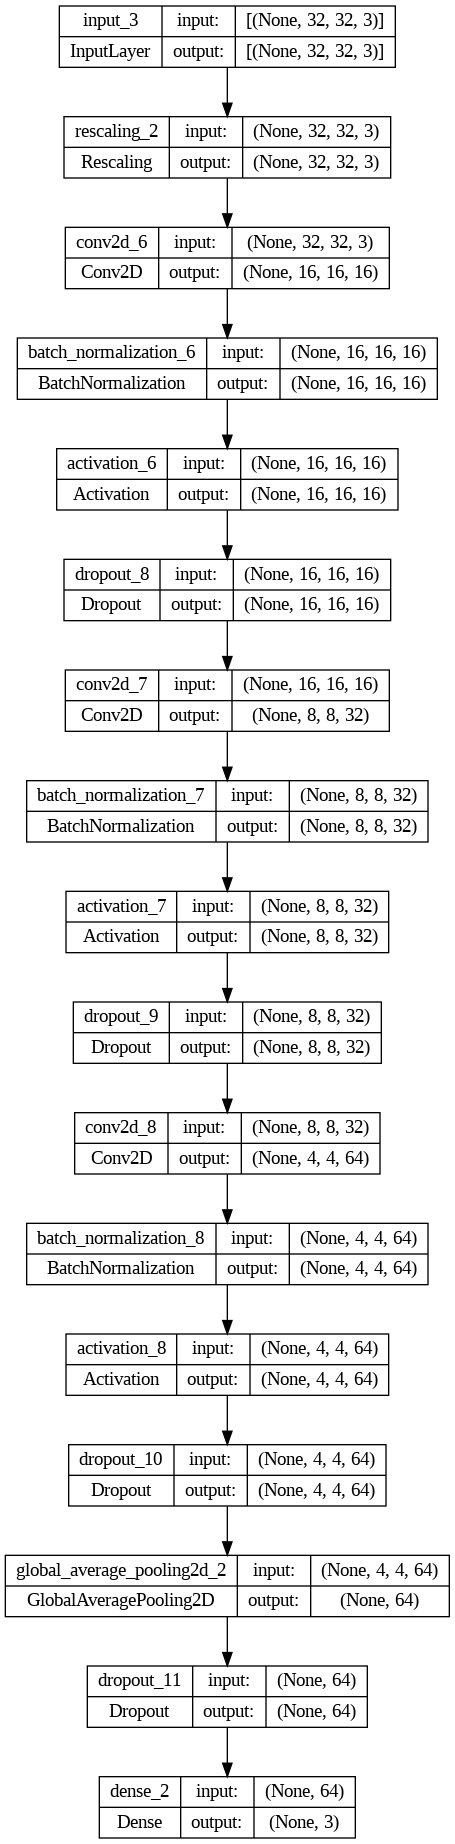

In [42]:
model_figure = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=3)
keras.utils.plot_model(model_figure, show_shapes=True)

In [43]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_figure_at_{epoch}.h5"),
]
model_figure.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_figure.fit(
    train_ds_figure, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_figure,
)

Epoch 1/30
45/45 [==============================] - 3s 17ms/step - loss: 0.6623 - accuracy: 0.4179 - val_loss: 0.6459 - val_accuracy: 0.4000
Epoch 2/30
45/45 [==============================] - 0s 9ms/step - loss: 0.6130 - accuracy: 0.4750 - val_loss: 0.6173 - val_accuracy: 0.4000
Epoch 3/30
45/45 [==============================] - 0s 8ms/step - loss: 0.5761 - accuracy: 0.5328 - val_loss: 0.6274 - val_accuracy: 0.4000
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.5499 - accuracy: 0.5758 - val_loss: 0.6527 - val_accuracy: 0.4000
Epoch 5/30
45/45 [==============================] - 0s 8ms/step - loss: 0.5226 - accuracy: 0.6328 - val_loss: 0.6784 - val_accuracy: 0.4000
Epoch 6/30
45/45 [==============================] - 1s 13ms/step - loss: 0.4893 - accuracy: 0.6751 - val_loss: 0.6701 - val_accuracy: 0.4000
Epoch 7/30
45/45 [==============================] - 1s 12ms/step - loss: 0.4697 - accuracy: 0.6942 - val_loss: 0.6383 - val_accuracy: 0.4000
Epoch 8/30
45/45 

이제부터 flag 분류 시작

In [44]:
def predict_image(filename, flag):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  if flag == 1:
    predictions = model_digit.predict(img_array).flatten()
  elif flag == 2:
    predictions = model_figure.predict(img_array).flatten()
  else:
    predictions = model_alphabet.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

index, score = predict_image("test_figure/star/0.png", 2)

print(index, score)

1/1 [==============================] - 0s 305ms/step
2 0.9993025


In [45]:
model_digit.save(SAVED_MODEL_DIGIT_FILENAME)
model_figure.save(SAVED_MODEL_FIGURE_FILENAME)
model_alphabet.save(SAVED_MODEL_ALPHABET_FILENAME)

In [46]:
# 숫자 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIGIT_FILENAME)
model_no_quant_tflite_digit = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_DIGIT_FILENAME, "wb").write(model_no_quant_tflite_digit)

def representative_dataset():
  for filename in glob.glob("test_digit/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_digit = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_DIGIT_FILENAME, "wb").write(model_tflite_digit)

31424

In [47]:
# 도형 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FIGURE_FILENAME)
model_no_quant_tflite_figure = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FIGURE_FILENAME, "wb").write(model_no_quant_tflite_figure)

def representative_dataset():
  for filename in glob.glob("test_figure/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_figure = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FIGURE_FILENAME, "wb").write(model_tflite_figure)

30952

In [48]:
# 알파벳 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_ALPHABET_FILENAME)
model_no_quant_tflite_alphabet = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_ALPHABET_FILENAME, "wb").write(model_no_quant_tflite_alphabet)

def representative_dataset():
  for filename in glob.glob("test_alphabet/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_alphabet = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_ALPHABET_FILENAME, "wb").write(model_tflite_alphabet)

32392

In [49]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [50]:
predict_tflite(model_tflite_digit, "test_digit/2/1.png")

(2, 0.94140625)

In [51]:
predict_tflite(model_tflite_figure, "test_figure/heart/1.png")

(1, 0.99609375)

In [52]:
predict_tflite(model_tflite_alphabet, "test_alphabet/a/0.png")

(0, 0.359375)

test_figure/star expected, 2 found with score 0.996094


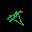

test_figure/star expected, 2 found with score 0.996094


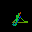

test_figure/star expected, 2 found with score 0.988281


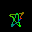

test_figure/star expected, 2 found with score 0.996094


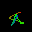

test_figure/star expected, 2 found with score 0.984375


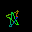

test_figure/star expected, 2 found with score 0.996094


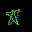

test_figure/star expected, 2 found with score 0.996094


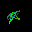

test_figure/star expected, 2 found with score 0.996094


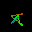

test_figure/star expected, 2 found with score 0.980469


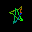

test_figure/star expected, 2 found with score 0.996094


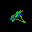

test_figure/star expected, 2 found with score 0.996094


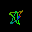

test_figure/star expected, 2 found with score 0.996094


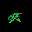

test_figure/star expected, 2 found with score 0.996094


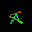

test_figure/star expected, 2 found with score 0.933594


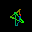

test_figure/star expected, 2 found with score 0.996094


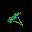

test_figure/star expected, 2 found with score 0.996094


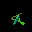

test_figure/star expected, 2 found with score 0.996094


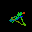

test_figure/star expected, 2 found with score 0.996094


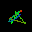

test_figure/star expected, 2 found with score 0.996094


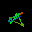

test_figure/star expected, 2 found with score 0.996094


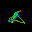

test_figure/star expected, 2 found with score 0.992188


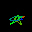

test_figure/star expected, 2 found with score 0.996094


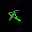

test_figure/star expected, 2 found with score 0.996094


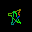

test_figure/star expected, 2 found with score 0.996094


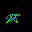

test_figure/star expected, 2 found with score 0.996094


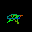

test_figure/star expected, 2 found with score 0.996094


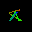

test_figure/star expected, 2 found with score 0.996094


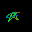

test_figure/star expected, 2 found with score 0.996094


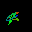

test_figure/star expected, 2 found with score 0.996094


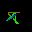

test_figure/star expected, 2 found with score 0.996094


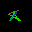

test_figure/star expected, 2 found with score 0.996094


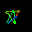

test_figure/star expected, 2 found with score 0.996094


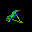

test_figure/star expected, 2 found with score 0.996094


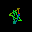

test_figure/star expected, 2 found with score 0.960938


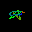

test_figure/star expected, 2 found with score 0.996094


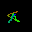

test_figure/star expected, 2 found with score 0.992188


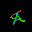

test_figure/star expected, 2 found with score 0.996094


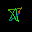

test_figure/star expected, 2 found with score 0.996094


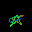

test_figure/star expected, 2 found with score 0.996094


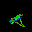

test_figure/star expected, 2 found with score 0.996094


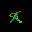

test_figure/star expected, 2 found with score 0.996094


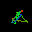

test_figure/star expected, 2 found with score 0.996094


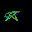

test_figure/star expected, 2 found with score 0.996094


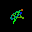

test_figure/circle expected, 0 found with score 0.808594


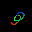

test_figure/circle expected, 1 found with score 0.812500


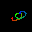

test_figure/circle expected, 0 found with score 0.996094


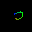

test_figure/circle expected, 0 found with score 0.992188


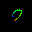

test_figure/circle expected, 0 found with score 0.996094


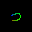

test_figure/circle expected, 0 found with score 0.996094


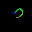

test_figure/circle expected, 0 found with score 0.992188


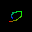

test_figure/circle expected, 0 found with score 0.996094


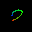

test_figure/circle expected, 0 found with score 0.996094


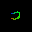

test_figure/circle expected, 0 found with score 0.996094


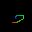

test_figure/circle expected, 0 found with score 0.996094


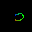

test_figure/circle expected, 0 found with score 0.996094


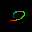

test_figure/circle expected, 0 found with score 0.996094


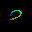

test_figure/circle expected, 0 found with score 0.996094


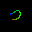

test_figure/circle expected, 0 found with score 0.992188


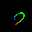

test_figure/circle expected, 0 found with score 0.933594


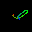

test_figure/circle expected, 0 found with score 0.996094


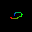

test_figure/circle expected, 0 found with score 0.996094


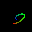

test_figure/circle expected, 0 found with score 0.988281


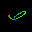

test_figure/circle expected, 0 found with score 0.984375


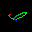

test_figure/circle expected, 1 found with score 0.796875


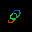

test_figure/circle expected, 0 found with score 0.945312


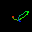

test_figure/circle expected, 0 found with score 0.996094


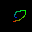

test_figure/circle expected, 0 found with score 0.925781


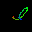

test_figure/circle expected, 0 found with score 0.992188


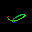

test_figure/circle expected, 0 found with score 0.996094


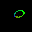

test_figure/circle expected, 0 found with score 0.996094


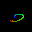

test_figure/circle expected, 0 found with score 0.996094


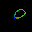

test_figure/circle expected, 0 found with score 0.996094


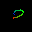

test_figure/circle expected, 0 found with score 0.996094


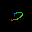

test_figure/circle expected, 0 found with score 0.996094


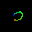

test_figure/circle expected, 0 found with score 0.996094


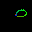

test_figure/circle expected, 0 found with score 0.996094


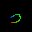

test_figure/circle expected, 0 found with score 0.996094


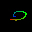

test_figure/circle expected, 0 found with score 0.996094


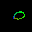

test_figure/circle expected, 0 found with score 0.996094


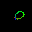

test_figure/circle expected, 0 found with score 0.996094


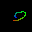

test_figure/circle expected, 0 found with score 0.992188


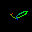

test_figure/circle expected, 0 found with score 0.996094


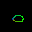

test_figure/circle expected, 0 found with score 0.996094


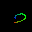

test_figure/circle expected, 0 found with score 0.996094


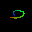

test_figure/circle expected, 0 found with score 0.996094


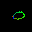

test_figure/circle expected, 0 found with score 0.992188


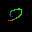

test_figure/circle expected, 0 found with score 0.996094


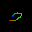

test_figure/circle expected, 0 found with score 0.996094


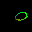

test_figure/circle expected, 0 found with score 0.988281


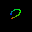

test_figure/circle expected, 0 found with score 0.996094


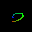

test_figure/circle expected, 0 found with score 0.996094


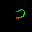

test_figure/circle expected, 0 found with score 0.996094


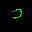

test_figure/circle expected, 0 found with score 0.996094


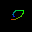

test_figure/circle expected, 0 found with score 0.996094


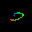

test_figure/circle expected, 0 found with score 0.996094


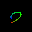

test_figure/circle expected, 0 found with score 0.996094


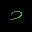

test_figure/circle expected, 0 found with score 0.996094


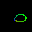

test_figure/circle expected, 0 found with score 0.996094


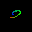

test_figure/circle expected, 0 found with score 0.996094


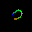

test_figure/circle expected, 0 found with score 0.996094


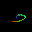

test_figure/circle expected, 0 found with score 0.996094


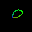

test_figure/circle expected, 0 found with score 0.921875


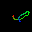

test_figure/circle expected, 0 found with score 0.996094


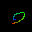

test_figure/circle expected, 0 found with score 0.992188


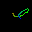

test_figure/circle expected, 1 found with score 0.902344


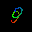

test_figure/circle expected, 0 found with score 0.996094


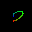

test_figure/circle expected, 1 found with score 0.957031


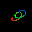

test_figure/circle expected, 0 found with score 0.996094


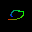

test_figure/circle expected, 0 found with score 0.992188


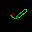

test_figure/circle expected, 0 found with score 0.996094


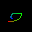

test_figure/circle expected, 0 found with score 0.996094


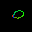

test_figure/circle expected, 0 found with score 0.996094


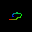

test_figure/circle expected, 0 found with score 0.996094


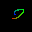

test_figure/heart expected, 1 found with score 0.953125


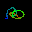

test_figure/heart expected, 1 found with score 0.996094


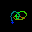

test_figure/heart expected, 1 found with score 0.988281


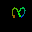

test_figure/heart expected, 1 found with score 0.949219


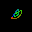

test_figure/heart expected, 1 found with score 0.996094


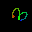

test_figure/heart expected, 1 found with score 0.992188


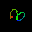

test_figure/heart expected, 0 found with score 0.972656


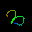

test_figure/heart expected, 1 found with score 0.988281


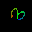

test_figure/heart expected, 1 found with score 0.984375


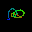

test_figure/heart expected, 1 found with score 0.929688


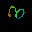

test_figure/heart expected, 1 found with score 0.980469


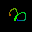

test_figure/heart expected, 1 found with score 0.972656


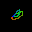

test_figure/heart expected, 1 found with score 0.933594


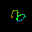

test_figure/heart expected, 1 found with score 0.992188


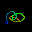

test_figure/heart expected, 1 found with score 0.972656


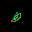

test_figure/heart expected, 1 found with score 0.996094


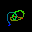

test_figure/heart expected, 1 found with score 0.996094


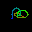

test_figure/heart expected, 1 found with score 0.996094


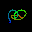

test_figure/heart expected, 1 found with score 0.996094


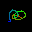

test_figure/heart expected, 1 found with score 0.921875


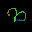

test_figure/heart expected, 1 found with score 0.910156


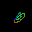

test_figure/heart expected, 1 found with score 0.988281


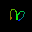

test_figure/heart expected, 1 found with score 0.992188


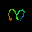

test_figure/heart expected, 0 found with score 0.968750


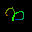

test_figure/heart expected, 0 found with score 0.964844


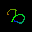

test_figure/heart expected, 1 found with score 0.839844


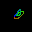

test_figure/heart expected, 1 found with score 0.875000


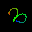

test_figure/heart expected, 1 found with score 0.937500


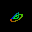

test_figure/heart expected, 1 found with score 0.964844


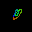

test_figure/heart expected, 1 found with score 0.984375


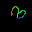

test_figure/heart expected, 1 found with score 0.988281


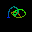

test_figure/heart expected, 1 found with score 0.972656


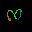

test_figure/heart expected, 0 found with score 0.902344


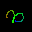

test_figure/heart expected, 1 found with score 0.960938


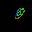

test_figure/heart expected, 1 found with score 0.820312


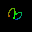

test_figure/heart expected, 1 found with score 0.964844


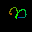

test_figure/heart expected, 1 found with score 0.996094


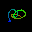

test_figure/heart expected, 1 found with score 0.828125


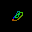

test_figure/heart expected, 1 found with score 0.996094


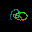

test_figure/heart expected, 1 found with score 0.957031


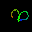

test_digit/0 expected, 0 found with score 0.996094


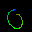

test_digit/0 expected, 0 found with score 0.984375


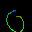

test_digit/0 expected, 0 found with score 0.933594


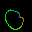

test_digit/0 expected, 0 found with score 0.988281


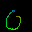

test_digit/0 expected, 0 found with score 0.960938


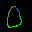

test_digit/0 expected, 0 found with score 0.996094


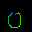

test_digit/0 expected, 0 found with score 0.937500


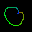

test_digit/0 expected, 0 found with score 0.964844


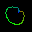

test_digit/0 expected, 0 found with score 0.917969


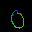

test_digit/0 expected, 0 found with score 0.988281


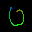

test_digit/0 expected, 0 found with score 0.968750


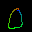

test_digit/0 expected, 0 found with score 0.996094


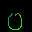

test_digit/0 expected, 0 found with score 0.894531


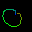

test_digit/0 expected, 0 found with score 0.906250


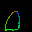

test_digit/0 expected, 0 found with score 0.984375


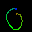

test_digit/0 expected, 0 found with score 0.941406


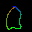

test_digit/0 expected, 0 found with score 0.968750


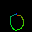

test_digit/0 expected, 0 found with score 0.941406


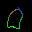

test_digit/0 expected, 0 found with score 0.835938


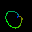

test_digit/0 expected, 0 found with score 0.968750


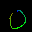

test_digit/0 expected, 0 found with score 0.933594


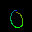

test_digit/0 expected, 0 found with score 0.992188


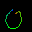

test_digit/0 expected, 0 found with score 0.972656


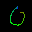

test_digit/0 expected, 0 found with score 0.976562


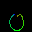

test_digit/0 expected, 0 found with score 0.941406


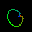

test_digit/0 expected, 0 found with score 0.820312


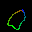

test_digit/0 expected, 0 found with score 0.996094


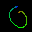

test_digit/0 expected, 0 found with score 0.996094


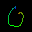

test_digit/0 expected, 0 found with score 0.992188


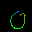

test_digit/0 expected, 0 found with score 0.996094


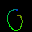

test_digit/0 expected, 0 found with score 0.984375


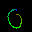

test_digit/0 expected, 0 found with score 0.976562


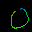

test_digit/0 expected, 0 found with score 0.996094


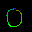

test_digit/0 expected, 0 found with score 0.996094


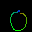

test_digit/0 expected, 0 found with score 0.988281


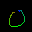

test_digit/0 expected, 0 found with score 0.988281


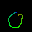

test_digit/0 expected, 0 found with score 0.984375


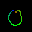

test_digit/0 expected, 0 found with score 0.996094


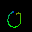

test_digit/0 expected, 0 found with score 0.921875


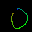

test_digit/0 expected, 0 found with score 0.964844


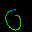

test_digit/0 expected, 0 found with score 0.992188


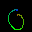

test_digit/0 expected, 0 found with score 0.968750


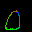

test_digit/0 expected, 0 found with score 0.949219


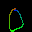

test_digit/0 expected, 0 found with score 0.972656


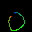

test_digit/0 expected, 0 found with score 0.882812


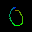

test_digit/0 expected, 0 found with score 0.980469


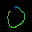

test_digit/0 expected, 0 found with score 0.933594


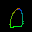

test_digit/0 expected, 0 found with score 0.992188


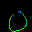

test_digit/0 expected, 0 found with score 0.984375


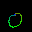

test_digit/0 expected, 0 found with score 0.996094


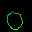

test_digit/0 expected, 0 found with score 0.964844


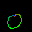

test_digit/0 expected, 0 found with score 0.945312


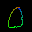

test_digit/0 expected, 0 found with score 0.988281


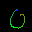

test_digit/0 expected, 0 found with score 0.996094


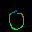

test_digit/0 expected, 0 found with score 0.910156


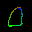

test_digit/0 expected, 0 found with score 0.980469


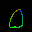

test_digit/0 expected, 0 found with score 0.878906


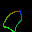

test_digit/0 expected, 0 found with score 0.910156


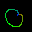

test_digit/0 expected, 0 found with score 0.769531


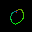

test_digit/0 expected, 0 found with score 0.937500


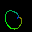

test_digit/0 expected, 0 found with score 0.890625


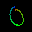

test_digit/0 expected, 0 found with score 0.976562


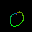

test_digit/0 expected, 0 found with score 0.976562


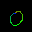

test_digit/0 expected, 0 found with score 0.847656


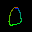

test_digit/0 expected, 0 found with score 0.953125


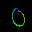

test_digit/0 expected, 0 found with score 0.980469


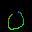

test_digit/0 expected, 0 found with score 0.910156


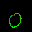

test_digit/0 expected, 0 found with score 0.972656


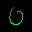

test_digit/0 expected, 0 found with score 0.875000


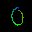

test_digit/0 expected, 0 found with score 0.968750


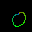

test_digit/0 expected, 0 found with score 0.996094


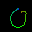

test_digit/0 expected, 0 found with score 0.859375


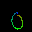

test_digit/0 expected, 0 found with score 0.992188


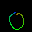

test_digit/0 expected, 0 found with score 0.945312


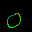

test_digit/0 expected, 0 found with score 0.964844


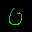

test_digit/0 expected, 0 found with score 0.996094


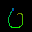

test_digit/0 expected, 0 found with score 0.992188


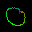

test_digit/0 expected, 0 found with score 0.996094


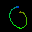

test_digit/0 expected, 0 found with score 0.886719


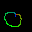

test_digit/0 expected, 0 found with score 0.992188


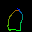

test_digit/0 expected, 0 found with score 0.933594


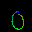

test_digit/0 expected, 0 found with score 0.996094


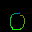

test_digit/0 expected, 0 found with score 0.988281


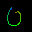

test_digit/0 expected, 0 found with score 0.996094


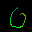

test_digit/0 expected, 0 found with score 0.984375


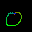

test_digit/0 expected, 0 found with score 0.984375


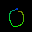

test_digit/0 expected, 0 found with score 0.960938


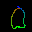

test_digit/0 expected, 0 found with score 0.929688


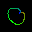

test_digit/0 expected, 0 found with score 0.996094


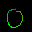

test_digit/0 expected, 0 found with score 0.957031


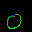

test_digit/0 expected, 0 found with score 0.953125


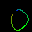

test_digit/0 expected, 0 found with score 0.960938


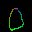

test_digit/0 expected, 0 found with score 0.964844


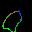

test_digit/0 expected, 0 found with score 0.898438


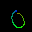

test_digit/0 expected, 0 found with score 0.984375


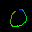

test_digit/0 expected, 0 found with score 0.996094


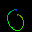

test_digit/0 expected, 0 found with score 0.992188


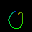

test_digit/0 expected, 0 found with score 0.988281


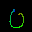

test_digit/0 expected, 0 found with score 0.988281


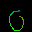

test_digit/0 expected, 0 found with score 0.996094


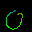

test_digit/0 expected, 0 found with score 0.894531


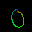

test_digit/0 expected, 0 found with score 0.988281


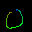

test_digit/0 expected, 0 found with score 0.960938


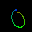

test_digit/0 expected, 0 found with score 0.968750


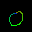

test_digit/0 expected, 0 found with score 0.996094


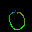

test_digit/0 expected, 0 found with score 0.996094


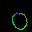

test_digit/5 expected, 5 found with score 0.921875


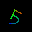

test_digit/5 expected, 5 found with score 0.988281


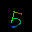

test_digit/5 expected, 5 found with score 0.757812


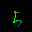

test_digit/5 expected, 5 found with score 0.890625


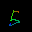

test_digit/5 expected, 5 found with score 0.964844


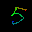

test_digit/5 expected, 5 found with score 0.957031


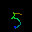

test_digit/5 expected, 5 found with score 0.949219


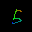

test_digit/5 expected, 5 found with score 0.925781


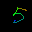

test_digit/5 expected, 5 found with score 0.871094


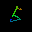

test_digit/5 expected, 5 found with score 0.980469


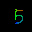

test_digit/5 expected, 5 found with score 0.902344


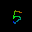

test_digit/5 expected, 5 found with score 0.828125


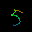

test_digit/5 expected, 5 found with score 0.929688


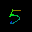

test_digit/5 expected, 5 found with score 0.984375


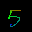

test_digit/5 expected, 5 found with score 0.820312


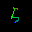

test_digit/5 expected, 5 found with score 0.980469


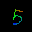

test_digit/5 expected, 5 found with score 0.949219


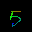

test_digit/5 expected, 5 found with score 0.953125


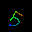

test_digit/5 expected, 5 found with score 0.960938


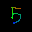

test_digit/5 expected, 5 found with score 0.914062


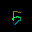

test_digit/5 expected, 5 found with score 0.972656


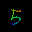

test_digit/5 expected, 5 found with score 0.886719


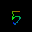

test_digit/5 expected, 5 found with score 0.984375


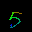

test_digit/5 expected, 5 found with score 0.968750


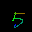

test_digit/5 expected, 5 found with score 0.980469


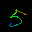

test_digit/5 expected, 5 found with score 0.917969


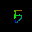

test_digit/5 expected, 5 found with score 0.968750


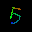

test_digit/5 expected, 5 found with score 0.984375


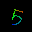

test_digit/5 expected, 5 found with score 0.796875


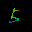

test_digit/5 expected, 5 found with score 0.816406


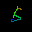

test_digit/5 expected, 5 found with score 0.773438


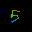

test_digit/5 expected, 5 found with score 0.851562


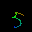

test_digit/5 expected, 5 found with score 0.941406


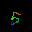

test_digit/5 expected, 5 found with score 0.820312


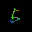

test_digit/5 expected, 5 found with score 0.910156


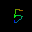

test_digit/5 expected, 5 found with score 0.875000


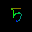

test_digit/5 expected, 5 found with score 0.898438


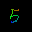

test_digit/5 expected, 5 found with score 0.839844


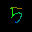

test_digit/5 expected, 5 found with score 0.871094


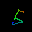

test_digit/5 expected, 5 found with score 0.871094


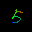

test_digit/5 expected, 5 found with score 0.902344


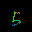

test_digit/5 expected, 5 found with score 0.832031


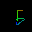

test_digit/5 expected, 5 found with score 0.820312


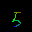

test_digit/5 expected, 5 found with score 0.781250


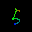

test_digit/5 expected, 5 found with score 0.902344


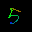

test_digit/5 expected, 5 found with score 0.886719


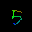

test_digit/5 expected, 5 found with score 0.937500


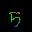

test_digit/5 expected, 5 found with score 0.957031


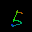

test_digit/5 expected, 5 found with score 0.921875


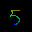

test_digit/5 expected, 5 found with score 0.929688


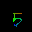

test_digit/5 expected, 5 found with score 0.914062


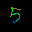

test_digit/5 expected, 5 found with score 0.800781


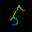

test_digit/5 expected, 5 found with score 0.968750


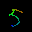

test_digit/5 expected, 5 found with score 0.871094


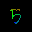

test_digit/5 expected, 5 found with score 0.968750


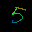

test_digit/5 expected, 5 found with score 0.906250


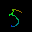

test_digit/5 expected, 5 found with score 0.957031


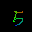

test_digit/5 expected, 5 found with score 0.851562


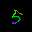

test_digit/5 expected, 5 found with score 0.769531


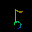

test_digit/5 expected, 5 found with score 0.914062


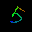

test_digit/5 expected, 5 found with score 0.839844


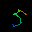

test_digit/5 expected, 5 found with score 0.859375


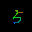

test_digit/5 expected, 5 found with score 0.875000


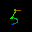

test_digit/5 expected, 5 found with score 0.902344


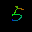

test_digit/5 expected, 5 found with score 0.937500


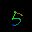

test_digit/5 expected, 5 found with score 0.800781


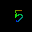

test_digit/5 expected, 5 found with score 0.847656


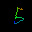

test_digit/5 expected, 5 found with score 0.976562


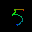

test_digit/5 expected, 5 found with score 0.871094


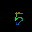

test_digit/5 expected, 5 found with score 0.996094


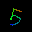

test_digit/5 expected, 5 found with score 0.960938


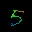

test_digit/5 expected, 5 found with score 0.906250


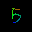

test_digit/5 expected, 5 found with score 0.953125


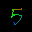

test_digit/5 expected, 5 found with score 0.824219


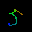

test_digit/5 expected, 5 found with score 0.792969


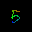

test_digit/5 expected, 5 found with score 0.796875


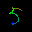

test_digit/5 expected, 5 found with score 0.875000


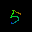

test_digit/5 expected, 5 found with score 0.925781


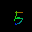

test_digit/5 expected, 5 found with score 0.761719


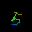

test_digit/4 expected, 4 found with score 0.906250


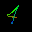

test_digit/4 expected, 4 found with score 0.996094


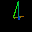

test_digit/4 expected, 4 found with score 0.824219


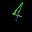

test_digit/4 expected, 4 found with score 0.984375


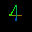

test_digit/4 expected, 4 found with score 0.960938


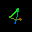

test_digit/4 expected, 4 found with score 0.992188


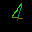

test_digit/4 expected, 4 found with score 0.996094


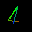

test_digit/4 expected, 4 found with score 0.984375


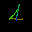

test_digit/4 expected, 4 found with score 0.960938


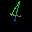

test_digit/4 expected, 4 found with score 0.988281


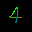

test_digit/4 expected, 4 found with score 0.996094


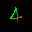

test_digit/4 expected, 4 found with score 0.996094


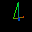

test_digit/4 expected, 4 found with score 0.996094


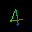

test_digit/4 expected, 4 found with score 0.949219


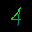

test_digit/4 expected, 4 found with score 0.984375


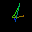

test_digit/4 expected, 4 found with score 0.910156


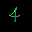

test_digit/4 expected, 4 found with score 0.976562


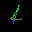

test_digit/4 expected, 4 found with score 0.992188


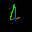

test_digit/4 expected, 4 found with score 0.996094


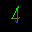

test_digit/4 expected, 4 found with score 0.875000


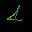

test_digit/4 expected, 4 found with score 0.785156


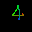

test_digit/4 expected, 4 found with score 0.988281


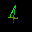

test_digit/4 expected, 4 found with score 0.972656


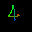

test_digit/4 expected, 4 found with score 0.996094


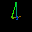

test_digit/4 expected, 4 found with score 0.996094


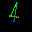

test_digit/4 expected, 4 found with score 0.941406


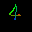

test_digit/4 expected, 4 found with score 0.980469


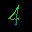

test_digit/4 expected, 4 found with score 0.957031


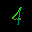

test_digit/4 expected, 4 found with score 0.925781


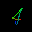

test_digit/4 expected, 4 found with score 0.976562


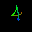

test_digit/4 expected, 4 found with score 0.828125


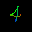

test_digit/4 expected, 4 found with score 0.996094


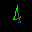

test_digit/4 expected, 4 found with score 0.945312


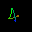

test_digit/4 expected, 4 found with score 0.925781


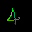

test_digit/4 expected, 4 found with score 0.996094


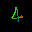

test_digit/4 expected, 4 found with score 0.996094


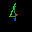

test_digit/4 expected, 4 found with score 0.937500


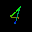

test_digit/4 expected, 4 found with score 0.941406


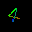

test_digit/4 expected, 4 found with score 0.976562


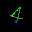

test_digit/4 expected, 4 found with score 0.996094


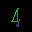

test_digit/4 expected, 4 found with score 0.996094


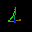

test_digit/4 expected, 4 found with score 0.980469


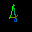

test_digit/4 expected, 4 found with score 0.972656


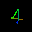

test_digit/4 expected, 4 found with score 0.957031


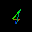

test_digit/4 expected, 4 found with score 0.953125


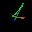

test_digit/4 expected, 4 found with score 0.835938


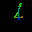

test_digit/4 expected, 4 found with score 0.949219


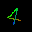

test_digit/4 expected, 4 found with score 0.957031


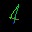

test_digit/4 expected, 4 found with score 0.984375


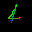

test_digit/4 expected, 4 found with score 0.980469


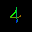

test_digit/4 expected, 4 found with score 0.949219


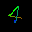

test_digit/4 expected, 4 found with score 0.968750


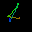

test_digit/4 expected, 4 found with score 0.992188


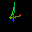

test_digit/4 expected, 4 found with score 0.996094


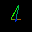

test_digit/4 expected, 4 found with score 0.882812


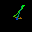

test_digit/4 expected, 4 found with score 0.941406


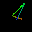

test_digit/4 expected, 4 found with score 0.824219


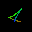

test_digit/4 expected, 4 found with score 0.945312


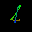

test_digit/4 expected, 4 found with score 0.960938


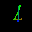

test_digit/4 expected, 4 found with score 0.906250


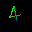

test_digit/4 expected, 4 found with score 0.988281


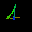

test_digit/4 expected, 4 found with score 0.996094


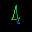

test_digit/4 expected, 4 found with score 0.808594


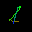

test_digit/4 expected, 4 found with score 0.792969


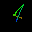

test_digit/4 expected, 4 found with score 0.996094


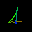

test_digit/4 expected, 4 found with score 0.914062


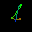

test_digit/4 expected, 4 found with score 0.886719


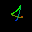

test_digit/4 expected, 4 found with score 0.957031


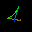

test_digit/4 expected, 4 found with score 0.843750


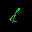

test_digit/4 expected, 4 found with score 0.957031


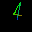

test_digit/4 expected, 4 found with score 0.988281


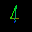

test_digit/4 expected, 4 found with score 0.906250


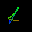

test_digit/4 expected, 4 found with score 0.984375


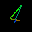

test_digit/4 expected, 4 found with score 0.964844


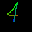

test_digit/4 expected, 4 found with score 0.996094


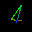

test_digit/4 expected, 4 found with score 0.957031


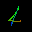

test_digit/4 expected, 4 found with score 0.929688


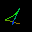

test_digit/4 expected, 4 found with score 0.785156


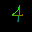

test_digit/4 expected, 4 found with score 0.992188


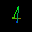

test_digit/4 expected, 4 found with score 0.972656


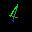

test_digit/4 expected, 4 found with score 0.812500


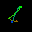

test_digit/4 expected, 4 found with score 0.960938


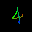

test_digit/4 expected, 4 found with score 0.851562


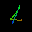

test_digit/4 expected, 4 found with score 0.996094


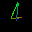

test_digit/4 expected, 4 found with score 0.800781


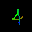

test_digit/4 expected, 4 found with score 0.996094


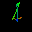

test_digit/4 expected, 4 found with score 0.996094


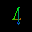

test_digit/4 expected, 4 found with score 0.984375


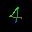

test_digit/4 expected, 4 found with score 0.800781


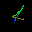

test_digit/4 expected, 4 found with score 0.992188


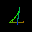

test_digit/4 expected, 4 found with score 0.996094


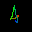

test_digit/4 expected, 4 found with score 0.988281


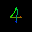

test_digit/4 expected, 4 found with score 0.996094


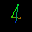

test_digit/4 expected, 4 found with score 0.984375


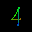

test_digit/4 expected, 4 found with score 0.890625


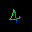

test_digit/4 expected, 4 found with score 0.921875


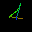

test_digit/4 expected, 4 found with score 0.988281


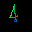

test_digit/4 expected, 4 found with score 0.890625


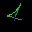

test_digit/4 expected, 4 found with score 0.894531


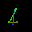

test_digit/4 expected, 4 found with score 0.933594


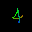

test_digit/4 expected, 4 found with score 0.972656


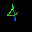

test_digit/9 expected, 9 found with score 0.988281


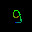

test_digit/9 expected, 9 found with score 0.957031


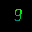

test_digit/9 expected, 9 found with score 0.933594


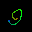

test_digit/9 expected, 9 found with score 0.980469


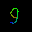

test_digit/9 expected, 9 found with score 0.996094


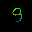

test_digit/9 expected, 9 found with score 0.878906


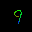

test_digit/9 expected, 9 found with score 0.937500


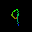

test_digit/9 expected, 9 found with score 0.992188


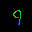

test_digit/9 expected, 9 found with score 0.933594


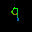

test_digit/9 expected, 9 found with score 0.968750


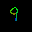

test_digit/9 expected, 9 found with score 0.941406


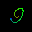

test_digit/9 expected, 9 found with score 0.976562


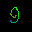

test_digit/9 expected, 9 found with score 0.988281


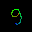

test_digit/9 expected, 9 found with score 0.992188


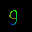

test_digit/9 expected, 9 found with score 0.992188


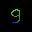

test_digit/9 expected, 9 found with score 0.976562


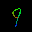

test_digit/9 expected, 9 found with score 0.968750


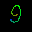

test_digit/9 expected, 9 found with score 0.984375


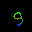

test_digit/9 expected, 9 found with score 0.984375


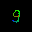

test_digit/9 expected, 9 found with score 0.957031


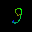

test_digit/9 expected, 9 found with score 0.972656


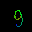

test_digit/9 expected, 9 found with score 0.984375


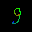

test_digit/9 expected, 9 found with score 0.941406


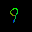

test_digit/9 expected, 9 found with score 0.988281


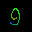

test_digit/9 expected, 9 found with score 0.992188


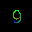

test_digit/9 expected, 9 found with score 0.996094


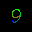

test_digit/9 expected, 9 found with score 0.996094


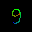

test_digit/9 expected, 9 found with score 0.925781


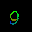

test_digit/9 expected, 9 found with score 0.917969


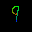

test_digit/9 expected, 9 found with score 0.992188


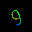

test_digit/9 expected, 9 found with score 0.937500


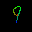

test_digit/9 expected, 9 found with score 0.996094


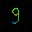

test_digit/9 expected, 9 found with score 0.988281


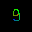

test_digit/9 expected, 9 found with score 0.988281


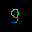

test_digit/9 expected, 9 found with score 0.898438


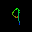

test_digit/9 expected, 9 found with score 0.992188


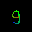

test_digit/9 expected, 9 found with score 0.980469


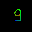

test_digit/9 expected, 9 found with score 0.996094


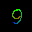

test_digit/9 expected, 9 found with score 0.992188


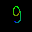

test_digit/9 expected, 9 found with score 0.984375


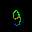

test_digit/9 expected, 9 found with score 0.957031


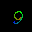

test_digit/9 expected, 9 found with score 0.921875


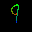

test_digit/9 expected, 9 found with score 0.980469


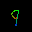

test_digit/9 expected, 9 found with score 0.894531


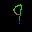

test_digit/9 expected, 9 found with score 0.894531


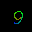

test_digit/9 expected, 9 found with score 0.980469


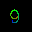

test_digit/9 expected, 9 found with score 0.964844


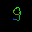

test_digit/9 expected, 9 found with score 0.996094


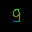

test_digit/9 expected, 9 found with score 0.972656


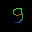

test_digit/9 expected, 9 found with score 0.996094


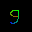

test_digit/9 expected, 9 found with score 0.890625


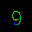

test_digit/9 expected, 9 found with score 0.972656


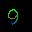

test_digit/9 expected, 9 found with score 0.941406


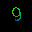

test_digit/9 expected, 9 found with score 0.996094


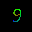

test_digit/9 expected, 9 found with score 0.890625


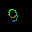

test_digit/9 expected, 9 found with score 0.964844


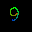

test_digit/9 expected, 9 found with score 0.996094


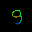

test_digit/9 expected, 9 found with score 0.925781


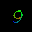

test_digit/9 expected, 9 found with score 0.933594


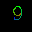

test_digit/9 expected, 9 found with score 0.992188


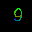

test_digit/9 expected, 9 found with score 0.949219


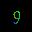

test_digit/9 expected, 9 found with score 0.976562


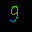

test_digit/9 expected, 9 found with score 0.972656


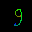

test_digit/9 expected, 9 found with score 0.992188


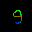

test_digit/9 expected, 9 found with score 0.988281


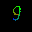

test_digit/9 expected, 9 found with score 0.968750


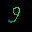

test_digit/9 expected, 9 found with score 0.992188


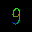

test_digit/9 expected, 9 found with score 0.996094


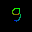

test_digit/9 expected, 9 found with score 0.988281


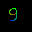

test_digit/9 expected, 9 found with score 0.988281


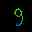

test_digit/9 expected, 9 found with score 0.863281


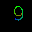

test_digit/9 expected, 9 found with score 0.992188


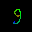

test_digit/9 expected, 9 found with score 0.957031


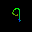

test_digit/9 expected, 9 found with score 0.972656


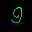

test_digit/9 expected, 9 found with score 0.984375


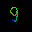

test_digit/9 expected, 9 found with score 0.972656


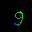

test_digit/9 expected, 9 found with score 0.937500


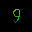

test_digit/9 expected, 9 found with score 0.855469


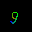

test_digit/9 expected, 9 found with score 0.957031


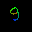

test_digit/9 expected, 9 found with score 0.957031


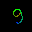

test_digit/9 expected, 9 found with score 0.957031


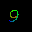

test_digit/9 expected, 9 found with score 0.984375


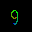

test_digit/9 expected, 9 found with score 0.980469


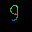

test_digit/9 expected, 9 found with score 0.984375


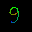

test_digit/9 expected, 9 found with score 0.972656


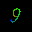

test_digit/9 expected, 9 found with score 0.964844


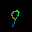

test_digit/9 expected, 9 found with score 0.992188


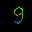

test_digit/9 expected, 9 found with score 0.996094


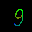

test_digit/9 expected, 9 found with score 0.988281


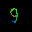

test_digit/9 expected, 9 found with score 0.996094


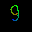

test_digit/9 expected, 9 found with score 0.996094


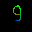

test_digit/9 expected, 9 found with score 0.941406


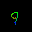

test_digit/9 expected, 9 found with score 0.957031


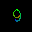

test_digit/9 expected, 9 found with score 0.984375


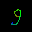

test_digit/9 expected, 9 found with score 0.972656


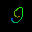

test_digit/9 expected, 9 found with score 0.968750


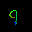

test_digit/9 expected, 9 found with score 0.992188


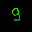

test_digit/9 expected, 9 found with score 0.949219


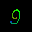

test_digit/9 expected, 9 found with score 0.898438


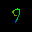

test_digit/9 expected, 9 found with score 0.953125


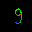

test_digit/9 expected, 9 found with score 0.992188


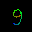

test_digit/9 expected, 9 found with score 0.992188


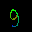

test_digit/9 expected, 9 found with score 0.996094


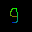

test_digit/9 expected, 9 found with score 0.984375


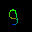

test_digit/9 expected, 9 found with score 0.851562


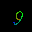

test_digit/9 expected, 9 found with score 0.980469


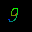

test_digit/9 expected, 9 found with score 0.976562


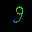

test_digit/9 expected, 9 found with score 0.984375


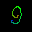

test_digit/9 expected, 9 found with score 0.976562


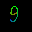

test_digit/9 expected, 9 found with score 0.960938


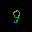

test_digit/9 expected, 9 found with score 0.996094


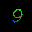

test_digit/9 expected, 9 found with score 0.988281


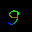

test_digit/9 expected, 9 found with score 0.976562


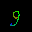

test_digit/9 expected, 9 found with score 0.992188


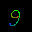

test_digit/9 expected, 9 found with score 0.972656


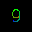

test_digit/9 expected, 9 found with score 0.953125


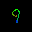

test_digit/9 expected, 9 found with score 0.980469


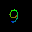

test_digit/9 expected, 9 found with score 0.992188


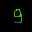

test_digit/9 expected, 9 found with score 0.960938


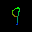

test_digit/9 expected, 9 found with score 0.996094


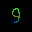

test_digit/9 expected, 9 found with score 0.980469


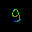

test_digit/9 expected, 9 found with score 0.796875


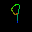

test_digit/9 expected, 9 found with score 0.960938


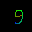

test_digit/9 expected, 9 found with score 0.988281


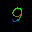

test_digit/9 expected, 9 found with score 0.980469


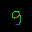

test_digit/9 expected, 9 found with score 0.902344


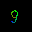

test_digit/9 expected, 9 found with score 0.996094


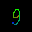

test_digit/9 expected, 9 found with score 0.992188


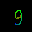

test_digit/7 expected, 7 found with score 0.851562


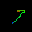

test_digit/7 expected, 7 found with score 0.910156


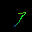

test_digit/7 expected, 7 found with score 0.835938


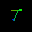

test_digit/7 expected, 7 found with score 0.933594


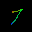

test_digit/7 expected, 7 found with score 0.984375


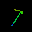

test_digit/7 expected, 7 found with score 0.980469


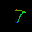

test_digit/7 expected, 7 found with score 0.902344


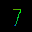

test_digit/7 expected, 7 found with score 0.972656


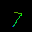

test_digit/7 expected, 7 found with score 0.867188


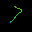

test_digit/7 expected, 7 found with score 0.972656


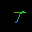

test_digit/7 expected, 7 found with score 0.949219


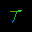

test_digit/7 expected, 7 found with score 0.957031


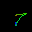

test_digit/7 expected, 7 found with score 0.984375


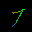

test_digit/7 expected, 7 found with score 0.972656


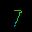

test_digit/7 expected, 7 found with score 0.941406


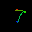

test_digit/7 expected, 7 found with score 0.957031


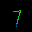

test_digit/7 expected, 7 found with score 0.851562


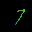

test_digit/7 expected, 7 found with score 0.996094


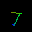

test_digit/7 expected, 7 found with score 0.957031


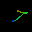

test_digit/7 expected, 7 found with score 0.976562


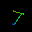

test_digit/7 expected, 7 found with score 0.898438


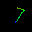

test_digit/7 expected, 7 found with score 0.890625


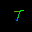

test_digit/7 expected, 7 found with score 0.972656


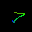

test_digit/7 expected, 7 found with score 0.964844


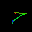

test_digit/7 expected, 7 found with score 0.984375


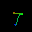

test_digit/7 expected, 7 found with score 0.847656


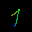

test_digit/7 expected, 7 found with score 0.921875


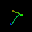

test_digit/7 expected, 7 found with score 0.914062


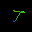

test_digit/7 expected, 7 found with score 0.914062


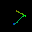

test_digit/7 expected, 7 found with score 0.960938


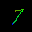

test_digit/7 expected, 7 found with score 0.988281


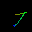

test_digit/7 expected, 7 found with score 0.984375


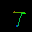

test_digit/7 expected, 7 found with score 0.851562


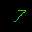

test_digit/7 expected, 7 found with score 0.953125


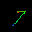

test_digit/7 expected, 7 found with score 0.972656


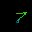

test_digit/7 expected, 7 found with score 0.937500


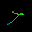

test_digit/7 expected, 7 found with score 0.992188


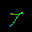

test_digit/7 expected, 7 found with score 0.792969


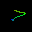

test_digit/7 expected, 7 found with score 0.878906


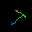

test_digit/7 expected, 7 found with score 0.875000


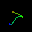

test_digit/7 expected, 7 found with score 0.929688


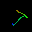

test_digit/7 expected, 7 found with score 0.945312


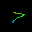

test_digit/7 expected, 7 found with score 0.980469


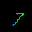

test_digit/7 expected, 7 found with score 0.964844


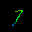

test_digit/7 expected, 7 found with score 0.980469


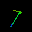

test_digit/7 expected, 7 found with score 0.980469


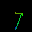

test_digit/7 expected, 7 found with score 0.933594


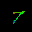

test_digit/7 expected, 7 found with score 0.921875


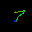

test_digit/7 expected, 7 found with score 0.968750


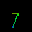

test_digit/7 expected, 7 found with score 0.902344


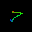

test_digit/7 expected, 7 found with score 0.921875


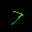

test_digit/7 expected, 7 found with score 0.890625


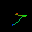

test_digit/7 expected, 7 found with score 0.898438


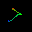

test_digit/7 expected, 7 found with score 0.972656


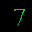

test_digit/7 expected, 7 found with score 0.968750


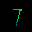

test_digit/7 expected, 7 found with score 0.976562


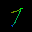

test_digit/7 expected, 7 found with score 0.906250


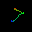

test_digit/7 expected, 7 found with score 0.933594


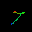

test_digit/7 expected, 7 found with score 0.964844


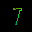

test_digit/7 expected, 7 found with score 0.957031


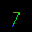

test_digit/7 expected, 7 found with score 0.972656


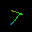

test_digit/7 expected, 7 found with score 0.980469


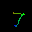

test_digit/7 expected, 7 found with score 0.964844


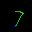

test_digit/7 expected, 7 found with score 0.988281


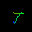

test_digit/7 expected, 7 found with score 0.980469


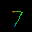

test_digit/7 expected, 7 found with score 0.972656


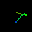

test_digit/7 expected, 7 found with score 0.828125


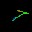

test_digit/7 expected, 7 found with score 0.972656


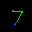

test_digit/7 expected, 7 found with score 0.945312


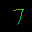

test_digit/7 expected, 7 found with score 0.964844


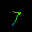

test_digit/7 expected, 7 found with score 0.851562


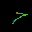

test_digit/7 expected, 7 found with score 0.914062


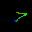

test_digit/7 expected, 7 found with score 0.953125


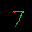

test_digit/7 expected, 7 found with score 0.937500


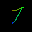

test_digit/7 expected, 7 found with score 0.917969


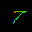

test_digit/7 expected, 7 found with score 0.929688


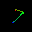

test_digit/7 expected, 7 found with score 0.992188


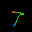

test_digit/7 expected, 7 found with score 0.878906


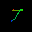

test_digit/7 expected, 7 found with score 0.960938


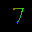

test_digit/7 expected, 7 found with score 0.933594


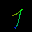

test_digit/7 expected, 7 found with score 0.871094


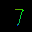

test_digit/7 expected, 7 found with score 0.886719


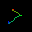

test_digit/7 expected, 7 found with score 0.843750


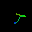

test_digit/7 expected, 7 found with score 0.933594


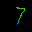

test_digit/7 expected, 7 found with score 0.921875


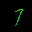

test_digit/7 expected, 7 found with score 0.976562


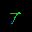

test_digit/7 expected, 7 found with score 0.812500


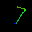

test_digit/7 expected, 7 found with score 0.980469


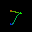

test_digit/7 expected, 7 found with score 0.972656


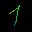

test_digit/7 expected, 7 found with score 0.988281


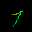

test_digit/7 expected, 7 found with score 0.953125


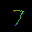

test_digit/7 expected, 7 found with score 0.781250


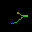

test_digit/7 expected, 7 found with score 0.972656


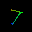

test_digit/7 expected, 7 found with score 0.933594


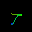

test_digit/7 expected, 7 found with score 0.808594


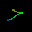

test_digit/7 expected, 7 found with score 0.984375


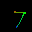

test_digit/7 expected, 7 found with score 0.910156


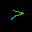

test_digit/7 expected, 7 found with score 0.976562


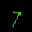

test_digit/7 expected, 7 found with score 0.988281


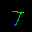

test_digit/7 expected, 7 found with score 0.929688


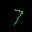

test_digit/7 expected, 7 found with score 0.898438


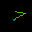

test_digit/7 expected, 7 found with score 0.902344


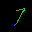

test_digit/7 expected, 7 found with score 0.964844


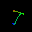

test_digit/7 expected, 7 found with score 0.972656


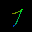

test_digit/7 expected, 7 found with score 0.796875


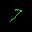

test_digit/7 expected, 7 found with score 0.957031


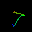

test_digit/7 expected, 7 found with score 0.886719


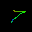

test_digit/7 expected, 7 found with score 0.945312


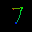

test_digit/7 expected, 7 found with score 0.953125


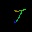

test_digit/7 expected, 7 found with score 0.835938


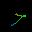

test_digit/1 expected, 1 found with score 0.984375


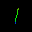

test_digit/1 expected, 1 found with score 0.992188


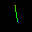

test_digit/1 expected, 1 found with score 0.996094


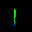

test_digit/1 expected, 1 found with score 0.968750


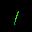

test_digit/1 expected, 1 found with score 0.859375


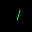

test_digit/1 expected, 1 found with score 0.992188


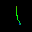

test_digit/1 expected, 1 found with score 0.949219


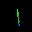

test_digit/1 expected, 1 found with score 0.964844


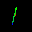

test_digit/1 expected, 1 found with score 0.988281


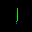

test_digit/1 expected, 1 found with score 0.976562


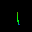

test_digit/1 expected, 1 found with score 0.964844


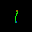

test_digit/1 expected, 1 found with score 0.949219


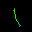

test_digit/1 expected, 1 found with score 0.988281


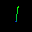

test_digit/1 expected, 1 found with score 0.949219


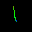

test_digit/1 expected, 1 found with score 0.984375


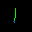

test_digit/1 expected, 1 found with score 0.976562


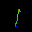

test_digit/1 expected, 1 found with score 0.992188


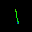

test_digit/1 expected, 1 found with score 0.980469


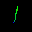

test_digit/1 expected, 1 found with score 0.996094


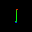

test_digit/1 expected, 1 found with score 0.988281


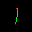

test_digit/1 expected, 1 found with score 0.996094


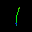

test_digit/1 expected, 1 found with score 0.933594


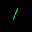

test_digit/1 expected, 1 found with score 0.968750


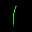

test_digit/1 expected, 1 found with score 0.996094


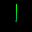

test_digit/1 expected, 1 found with score 0.984375


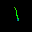

test_digit/1 expected, 1 found with score 0.972656


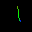

test_digit/1 expected, 1 found with score 0.917969


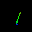

test_digit/1 expected, 1 found with score 0.957031


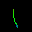

test_digit/1 expected, 1 found with score 0.976562


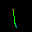

test_digit/1 expected, 1 found with score 0.945312


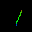

test_digit/1 expected, 1 found with score 0.980469


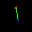

test_digit/1 expected, 1 found with score 0.988281


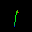

test_digit/1 expected, 1 found with score 0.992188


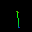

test_digit/1 expected, 1 found with score 0.980469


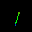

test_digit/1 expected, 1 found with score 0.992188


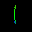

test_digit/1 expected, 1 found with score 0.964844


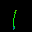

test_digit/1 expected, 1 found with score 0.953125


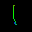

test_digit/1 expected, 1 found with score 0.906250


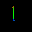

test_digit/1 expected, 1 found with score 0.992188


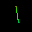

test_digit/1 expected, 1 found with score 0.992188


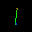

test_digit/1 expected, 1 found with score 0.957031


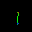

test_digit/1 expected, 1 found with score 0.898438


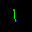

test_digit/1 expected, 1 found with score 0.949219


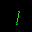

test_digit/1 expected, 1 found with score 0.996094


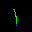

test_digit/1 expected, 1 found with score 0.902344


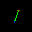

test_digit/1 expected, 1 found with score 0.953125


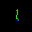

test_digit/1 expected, 1 found with score 0.914062


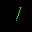

test_digit/1 expected, 1 found with score 0.773438


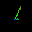

test_digit/1 expected, 1 found with score 0.972656


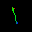

test_digit/1 expected, 1 found with score 0.984375


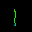

test_digit/1 expected, 1 found with score 0.832031


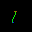

test_digit/1 expected, 1 found with score 0.953125


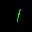

test_digit/1 expected, 1 found with score 0.960938


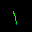

test_digit/1 expected, 1 found with score 0.996094


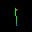

test_digit/1 expected, 1 found with score 0.773438


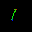

test_digit/1 expected, 1 found with score 0.992188


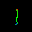

test_digit/1 expected, 1 found with score 0.984375


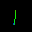

test_digit/1 expected, 1 found with score 0.996094


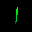

test_digit/1 expected, 1 found with score 0.980469


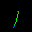

test_digit/1 expected, 1 found with score 0.972656


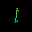

test_digit/1 expected, 1 found with score 0.976562


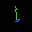

test_digit/1 expected, 1 found with score 0.835938


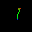

test_digit/1 expected, 1 found with score 0.949219


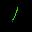

test_digit/1 expected, 1 found with score 0.972656


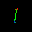

test_digit/1 expected, 1 found with score 0.949219


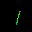

test_digit/1 expected, 1 found with score 0.996094


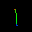

test_digit/1 expected, 1 found with score 0.988281


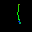

test_digit/1 expected, 1 found with score 0.949219


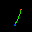

test_digit/1 expected, 1 found with score 0.972656


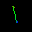

test_digit/1 expected, 1 found with score 0.921875


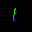

test_digit/1 expected, 1 found with score 0.972656


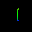

test_digit/1 expected, 1 found with score 0.988281


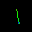

test_digit/1 expected, 1 found with score 0.992188


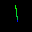

test_digit/1 expected, 1 found with score 0.957031


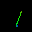

test_digit/1 expected, 1 found with score 0.832031


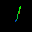

test_digit/1 expected, 1 found with score 0.953125


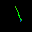

test_digit/1 expected, 1 found with score 0.992188


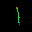

test_digit/1 expected, 1 found with score 0.980469


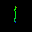

test_digit/1 expected, 1 found with score 0.980469


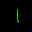

test_digit/1 expected, 1 found with score 0.968750


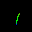

test_digit/1 expected, 1 found with score 0.953125


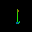

test_digit/1 expected, 1 found with score 0.988281


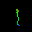

test_digit/1 expected, 1 found with score 0.890625


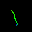

test_digit/1 expected, 1 found with score 0.937500


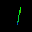

test_digit/1 expected, 1 found with score 0.992188


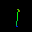

test_digit/1 expected, 1 found with score 0.933594


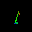

test_digit/1 expected, 1 found with score 0.949219


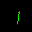

test_digit/1 expected, 1 found with score 0.968750


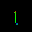

test_digit/1 expected, 1 found with score 0.882812


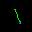

test_digit/1 expected, 1 found with score 0.988281


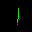

test_digit/1 expected, 1 found with score 0.976562


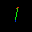

test_digit/1 expected, 1 found with score 0.996094


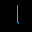

test_digit/1 expected, 1 found with score 0.996094


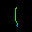

test_digit/1 expected, 1 found with score 0.980469


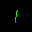

test_digit/1 expected, 1 found with score 0.992188


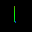

test_digit/1 expected, 1 found with score 0.980469


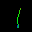

test_digit/1 expected, 1 found with score 0.992188


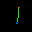

test_digit/1 expected, 1 found with score 0.964844


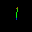

test_digit/1 expected, 1 found with score 0.917969


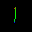

test_digit/1 expected, 1 found with score 0.925781


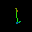

test_digit/1 expected, 1 found with score 0.957031


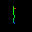

test_digit/1 expected, 1 found with score 0.996094


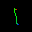

test_digit/2 expected, 2 found with score 0.945312


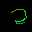

test_digit/2 expected, 2 found with score 0.949219


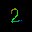

test_digit/2 expected, 2 found with score 0.890625


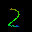

test_digit/2 expected, 2 found with score 0.914062


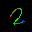

test_digit/2 expected, 2 found with score 0.949219


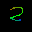

test_digit/2 expected, 2 found with score 0.804688


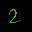

test_digit/2 expected, 2 found with score 0.902344


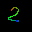

test_digit/2 expected, 2 found with score 0.960938


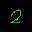

test_digit/2 expected, 2 found with score 0.984375


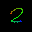

test_digit/2 expected, 2 found with score 0.839844


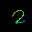

test_digit/2 expected, 2 found with score 0.863281


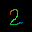

test_digit/2 expected, 2 found with score 0.871094


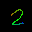

test_digit/2 expected, 2 found with score 0.878906


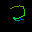

test_digit/2 expected, 2 found with score 0.953125


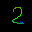

test_digit/2 expected, 2 found with score 0.933594


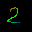

test_digit/2 expected, 2 found with score 0.968750


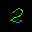

test_digit/2 expected, 2 found with score 0.960938


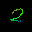

test_digit/2 expected, 2 found with score 0.917969


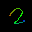

test_digit/2 expected, 2 found with score 0.808594


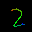

test_digit/2 expected, 2 found with score 0.929688


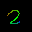

test_digit/2 expected, 2 found with score 0.808594


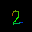

test_digit/2 expected, 2 found with score 0.847656


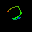

test_digit/2 expected, 2 found with score 0.910156


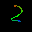

test_digit/2 expected, 2 found with score 0.984375


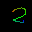

test_digit/2 expected, 2 found with score 0.937500


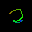

test_digit/2 expected, 2 found with score 0.917969


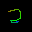

test_digit/2 expected, 2 found with score 0.972656


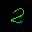

test_digit/2 expected, 2 found with score 0.972656


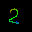

test_digit/2 expected, 2 found with score 0.773438


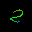

test_digit/2 expected, 2 found with score 0.753906


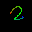

test_digit/2 expected, 2 found with score 0.972656


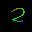

test_digit/2 expected, 2 found with score 0.906250


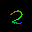

test_digit/2 expected, 2 found with score 0.851562


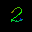

test_digit/2 expected, 2 found with score 0.769531


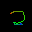

test_digit/2 expected, 2 found with score 0.941406


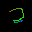

test_digit/2 expected, 2 found with score 0.929688


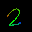

test_digit/2 expected, 2 found with score 0.917969


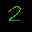

test_digit/2 expected, 2 found with score 0.843750


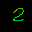

test_digit/2 expected, 2 found with score 0.843750


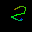

test_digit/2 expected, 2 found with score 0.957031


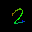

test_digit/2 expected, 2 found with score 0.945312


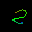

test_digit/2 expected, 2 found with score 0.960938


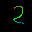

test_digit/2 expected, 2 found with score 0.871094


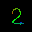

test_digit/2 expected, 2 found with score 0.976562


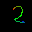

test_digit/2 expected, 2 found with score 0.957031


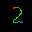

test_digit/2 expected, 2 found with score 0.980469


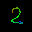

test_digit/2 expected, 2 found with score 0.957031


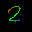

test_digit/2 expected, 2 found with score 0.910156


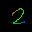

test_digit/2 expected, 2 found with score 0.964844


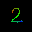

test_digit/2 expected, 2 found with score 0.843750


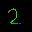

test_digit/2 expected, 2 found with score 0.957031


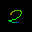

test_digit/2 expected, 2 found with score 0.925781


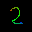

test_digit/2 expected, 2 found with score 0.914062


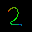

test_digit/2 expected, 2 found with score 0.937500


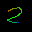

test_digit/2 expected, 2 found with score 0.832031


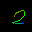

test_digit/2 expected, 2 found with score 0.933594


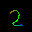

test_digit/2 expected, 2 found with score 0.777344


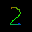

test_digit/2 expected, 2 found with score 0.984375


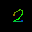

test_digit/2 expected, 2 found with score 0.800781


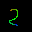

test_digit/2 expected, 2 found with score 0.980469


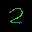

test_digit/2 expected, 2 found with score 0.968750


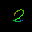

test_digit/2 expected, 2 found with score 0.847656


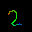

test_digit/2 expected, 2 found with score 0.917969


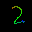

test_digit/2 expected, 2 found with score 0.781250


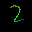

test_digit/2 expected, 2 found with score 0.828125


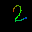

test_digit/2 expected, 2 found with score 0.929688


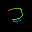

test_digit/2 expected, 2 found with score 0.890625


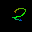

test_digit/2 expected, 2 found with score 0.953125


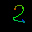

test_digit/2 expected, 2 found with score 0.757812


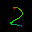

test_digit/2 expected, 2 found with score 0.945312


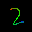

test_digit/2 expected, 2 found with score 0.843750


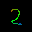

test_digit/2 expected, 2 found with score 0.968750


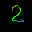

test_digit/2 expected, 2 found with score 0.859375


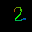

test_digit/2 expected, 2 found with score 0.933594


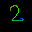

test_digit/2 expected, 2 found with score 0.972656


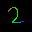

test_digit/2 expected, 2 found with score 0.828125


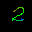

test_digit/2 expected, 2 found with score 0.964844


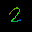

test_digit/2 expected, 2 found with score 0.906250


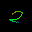

test_digit/2 expected, 2 found with score 0.968750


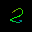

test_digit/2 expected, 2 found with score 0.988281


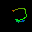

test_digit/2 expected, 2 found with score 0.988281


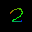

test_digit/2 expected, 2 found with score 0.765625


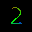

test_digit/2 expected, 2 found with score 0.964844


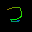

test_digit/2 expected, 2 found with score 0.910156


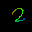

test_digit/2 expected, 2 found with score 0.753906


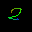

test_digit/2 expected, 2 found with score 0.871094


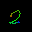

test_digit/2 expected, 2 found with score 0.925781


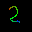

test_digit/2 expected, 2 found with score 0.882812


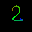

test_digit/2 expected, 2 found with score 0.945312


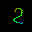

test_digit/6 expected, 6 found with score 0.781250


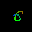

test_digit/6 expected, 6 found with score 0.906250


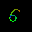

test_digit/6 expected, 6 found with score 0.804688


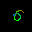

test_digit/6 expected, 6 found with score 0.886719


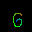

test_digit/6 expected, 6 found with score 0.980469


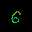

test_digit/6 expected, 6 found with score 0.890625


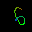

test_digit/6 expected, 6 found with score 0.898438


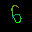

test_digit/6 expected, 6 found with score 0.828125


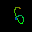

test_digit/6 expected, 6 found with score 0.894531


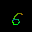

test_digit/6 expected, 6 found with score 0.921875


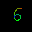

test_digit/6 expected, 6 found with score 0.925781


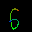

test_digit/6 expected, 6 found with score 0.796875


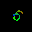

test_digit/6 expected, 6 found with score 0.960938


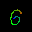

test_digit/6 expected, 6 found with score 0.855469


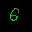

test_digit/6 expected, 6 found with score 0.917969


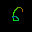

test_digit/6 expected, 6 found with score 0.808594


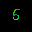

test_digit/6 expected, 6 found with score 0.910156


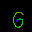

test_digit/6 expected, 6 found with score 0.753906


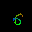

test_digit/6 expected, 6 found with score 0.886719


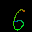

test_digit/6 expected, 6 found with score 0.890625


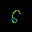

test_digit/6 expected, 6 found with score 0.917969


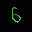

test_digit/6 expected, 6 found with score 0.921875


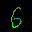

test_digit/6 expected, 6 found with score 0.929688


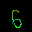

test_digit/6 expected, 6 found with score 0.906250


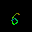

test_digit/6 expected, 6 found with score 0.902344


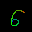

test_digit/6 expected, 6 found with score 0.964844


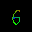

test_digit/6 expected, 6 found with score 0.972656


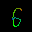

test_digit/6 expected, 6 found with score 0.914062


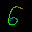

test_digit/6 expected, 6 found with score 0.953125


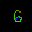

test_digit/6 expected, 6 found with score 0.890625


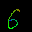

test_digit/6 expected, 6 found with score 0.929688


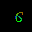

test_digit/6 expected, 6 found with score 0.925781


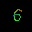

test_digit/6 expected, 6 found with score 0.960938


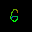

test_digit/6 expected, 6 found with score 0.925781


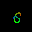

test_digit/6 expected, 6 found with score 0.941406


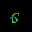

test_digit/6 expected, 6 found with score 0.753906


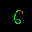

test_digit/6 expected, 6 found with score 0.917969


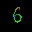

test_digit/6 expected, 6 found with score 0.921875


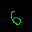

test_digit/6 expected, 6 found with score 0.875000


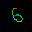

test_digit/6 expected, 6 found with score 0.941406


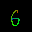

test_digit/6 expected, 6 found with score 0.960938


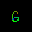

test_digit/6 expected, 6 found with score 0.886719


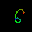

test_digit/6 expected, 6 found with score 0.914062


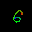

test_digit/6 expected, 6 found with score 0.898438


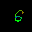

test_digit/6 expected, 6 found with score 0.917969


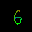

test_digit/6 expected, 6 found with score 0.921875


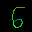

test_digit/6 expected, 6 found with score 0.917969


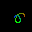

test_digit/6 expected, 6 found with score 0.750000


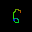

test_digit/6 expected, 6 found with score 0.925781


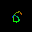

test_digit/6 expected, 6 found with score 0.941406


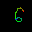

test_digit/6 expected, 6 found with score 0.882812


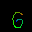

test_digit/6 expected, 6 found with score 0.976562


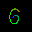

test_digit/6 expected, 6 found with score 0.960938


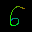

test_digit/6 expected, 6 found with score 0.937500


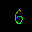

test_digit/6 expected, 6 found with score 0.968750


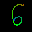

test_digit/6 expected, 6 found with score 0.902344


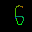

test_digit/6 expected, 6 found with score 0.964844


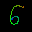

test_digit/6 expected, 6 found with score 0.898438


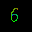

test_digit/6 expected, 6 found with score 0.808594


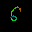

test_digit/6 expected, 6 found with score 0.925781


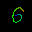

test_digit/6 expected, 6 found with score 0.914062


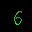

test_digit/6 expected, 6 found with score 0.964844


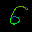

test_digit/6 expected, 6 found with score 0.925781


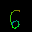

test_digit/6 expected, 6 found with score 0.945312


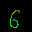

test_digit/6 expected, 6 found with score 0.933594


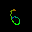

test_digit/6 expected, 6 found with score 0.855469


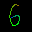

test_digit/6 expected, 6 found with score 0.960938


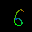

test_digit/6 expected, 6 found with score 0.976562


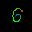

test_digit/6 expected, 6 found with score 0.886719


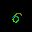

test_digit/6 expected, 6 found with score 0.839844


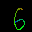

test_digit/6 expected, 6 found with score 0.933594


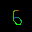

test_digit/6 expected, 6 found with score 0.976562


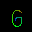

test_digit/6 expected, 6 found with score 0.960938


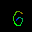

test_digit/6 expected, 6 found with score 0.843750


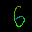

test_digit/6 expected, 6 found with score 0.957031


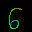

test_digit/6 expected, 6 found with score 0.957031


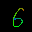

test_digit/6 expected, 6 found with score 0.824219


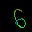

test_digit/6 expected, 6 found with score 0.960938


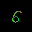

test_digit/6 expected, 6 found with score 0.929688


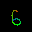

test_digit/6 expected, 6 found with score 0.949219


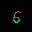

test_digit/6 expected, 6 found with score 0.937500


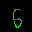

test_digit/6 expected, 6 found with score 0.988281


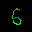

test_digit/6 expected, 6 found with score 0.980469


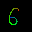

test_digit/6 expected, 6 found with score 0.984375


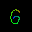

test_digit/6 expected, 6 found with score 0.976562


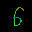

test_digit/6 expected, 6 found with score 0.910156


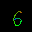

test_digit/6 expected, 6 found with score 0.902344


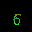

test_digit/6 expected, 6 found with score 0.960938


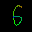

test_digit/6 expected, 6 found with score 0.796875


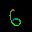

test_digit/6 expected, 6 found with score 0.941406


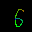

test_digit/6 expected, 6 found with score 0.949219


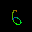

test_digit/6 expected, 6 found with score 0.828125


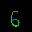

test_digit/6 expected, 6 found with score 0.882812


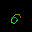

test_digit/6 expected, 6 found with score 0.894531


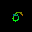

test_digit/6 expected, 6 found with score 0.921875


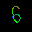

test_digit/6 expected, 6 found with score 0.867188


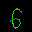

test_digit/6 expected, 6 found with score 0.773438


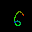

test_digit/6 expected, 6 found with score 0.976562


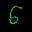

test_digit/6 expected, 6 found with score 0.906250


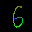

test_digit/6 expected, 6 found with score 0.886719


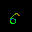

test_digit/6 expected, 6 found with score 0.937500


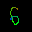

test_digit/6 expected, 6 found with score 0.839844


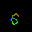

test_digit/6 expected, 6 found with score 0.894531


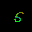

test_digit/6 expected, 6 found with score 0.800781


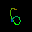

test_digit/6 expected, 6 found with score 0.902344


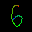

test_digit/6 expected, 6 found with score 0.949219


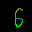

test_digit/6 expected, 6 found with score 0.976562


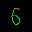

test_digit/6 expected, 6 found with score 0.800781


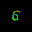

test_digit/6 expected, 6 found with score 0.953125


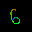

test_digit/6 expected, 6 found with score 0.957031


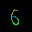

test_digit/6 expected, 6 found with score 0.929688


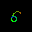

test_digit/6 expected, 6 found with score 0.960938


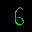

test_digit/6 expected, 6 found with score 0.871094


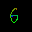

test_digit/6 expected, 6 found with score 0.781250


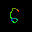

test_digit/6 expected, 6 found with score 0.964844


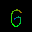

test_digit/6 expected, 6 found with score 0.906250


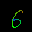

test_digit/6 expected, 6 found with score 0.941406


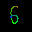

test_digit/6 expected, 6 found with score 0.890625


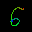

test_digit/6 expected, 6 found with score 0.964844


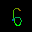

test_digit/6 expected, 6 found with score 0.933594


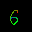

test_digit/6 expected, 6 found with score 0.898438


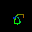

test_digit/6 expected, 6 found with score 0.890625


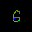

test_digit/6 expected, 6 found with score 0.859375


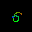

test_digit/6 expected, 6 found with score 0.902344


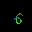

test_digit/6 expected, 6 found with score 0.957031


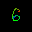

test_digit/6 expected, 6 found with score 0.906250


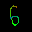

test_digit/6 expected, 6 found with score 0.925781


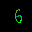

test_digit/6 expected, 6 found with score 0.953125


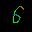

test_digit/6 expected, 6 found with score 0.894531


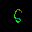

test_digit/6 expected, 6 found with score 0.894531


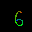

test_digit/6 expected, 6 found with score 0.953125


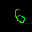

test_digit/6 expected, 6 found with score 0.875000


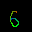

test_digit/3 expected, 3 found with score 0.789062


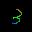

test_digit/3 expected, 3 found with score 0.820312


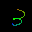

test_digit/3 expected, 3 found with score 0.750000


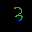

test_digit/3 expected, 3 found with score 0.808594


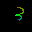

test_digit/3 expected, 3 found with score 0.816406


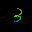

test_digit/3 expected, 3 found with score 0.800781


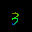

test_digit/3 expected, 3 found with score 0.828125


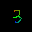

test_digit/3 expected, 3 found with score 0.765625


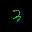

test_digit/3 expected, 3 found with score 0.855469


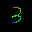

test_digit/3 expected, 3 found with score 0.816406


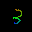

test_digit/3 expected, 3 found with score 0.816406


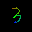

test_digit/3 expected, 3 found with score 0.789062


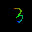

test_digit/3 expected, 3 found with score 0.761719


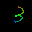

test_digit/3 expected, 3 found with score 0.882812


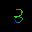

test_digit/3 expected, 3 found with score 0.894531


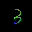

test_digit/3 expected, 3 found with score 0.800781


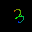

test_digit/3 expected, 3 found with score 0.789062


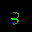

test_digit/3 expected, 3 found with score 0.765625


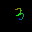

test_digit/3 expected, 3 found with score 0.808594


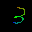

test_digit/3 expected, 3 found with score 0.847656


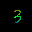

test_digit/3 expected, 3 found with score 0.843750


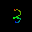

test_digit/3 expected, 3 found with score 0.753906


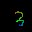

test_digit/3 expected, 3 found with score 0.859375


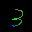

test_digit/3 expected, 3 found with score 0.777344


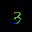

test_digit/3 expected, 3 found with score 0.824219


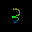

test_digit/3 expected, 3 found with score 0.847656


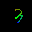

test_digit/3 expected, 3 found with score 0.761719


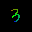

test_digit/3 expected, 3 found with score 0.886719


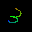

test_digit/3 expected, 3 found with score 0.839844


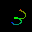

test_digit/3 expected, 3 found with score 0.824219


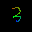

test_digit/3 expected, 3 found with score 0.832031


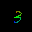

test_digit/3 expected, 3 found with score 0.847656


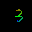

test_digit/3 expected, 3 found with score 0.902344


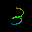

test_digit/3 expected, 3 found with score 0.773438


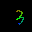

test_digit/3 expected, 3 found with score 0.832031


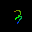

test_digit/3 expected, 3 found with score 0.769531


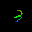

test_digit/3 expected, 3 found with score 0.855469


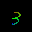

test_digit/3 expected, 3 found with score 0.761719


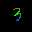

test_digit/8 expected, 8 found with score 0.964844


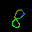

test_digit/8 expected, 8 found with score 0.984375


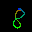

test_digit/8 expected, 8 found with score 0.972656


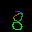

test_digit/8 expected, 8 found with score 0.789062


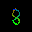

test_digit/8 expected, 8 found with score 0.886719


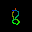

test_digit/8 expected, 8 found with score 0.886719


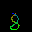

test_digit/8 expected, 8 found with score 0.960938


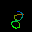

test_digit/8 expected, 8 found with score 0.953125


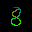

test_digit/8 expected, 8 found with score 0.871094


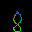

test_digit/8 expected, 8 found with score 0.855469


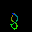

test_digit/8 expected, 8 found with score 0.960938


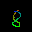

test_digit/8 expected, 8 found with score 0.992188


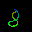

test_digit/8 expected, 8 found with score 0.902344


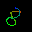

test_digit/8 expected, 8 found with score 0.968750


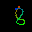

test_digit/8 expected, 8 found with score 0.984375


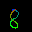

test_digit/8 expected, 8 found with score 0.957031


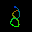

test_digit/8 expected, 8 found with score 0.988281


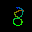

test_digit/8 expected, 8 found with score 0.992188


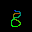

test_digit/8 expected, 8 found with score 0.980469


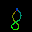

test_digit/8 expected, 8 found with score 0.980469


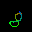

test_digit/8 expected, 8 found with score 0.976562


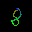

test_digit/8 expected, 8 found with score 0.992188


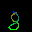

test_digit/8 expected, 8 found with score 0.976562


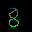

test_digit/8 expected, 8 found with score 0.964844


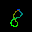

test_digit/8 expected, 8 found with score 0.824219


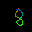

test_digit/8 expected, 8 found with score 0.960938


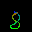

test_digit/8 expected, 8 found with score 0.953125


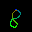

test_digit/8 expected, 8 found with score 0.902344


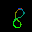

test_digit/8 expected, 8 found with score 0.960938


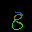

test_digit/8 expected, 8 found with score 0.964844


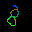

test_digit/8 expected, 8 found with score 0.996094


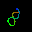

test_digit/8 expected, 8 found with score 0.984375


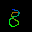

test_digit/8 expected, 8 found with score 0.960938


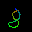

test_digit/8 expected, 8 found with score 0.976562


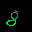

test_digit/8 expected, 8 found with score 0.964844


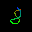

test_digit/8 expected, 8 found with score 0.886719


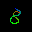

test_digit/8 expected, 8 found with score 0.917969


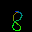

test_digit/8 expected, 8 found with score 0.859375


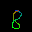

test_digit/8 expected, 8 found with score 0.988281


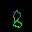

test_digit/8 expected, 8 found with score 0.960938


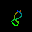

test_digit/8 expected, 8 found with score 0.757812


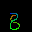

test_digit/8 expected, 8 found with score 0.968750


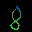

test_digit/8 expected, 8 found with score 0.894531


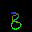

test_digit/8 expected, 8 found with score 0.984375


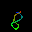

test_digit/8 expected, 8 found with score 0.781250


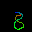

test_digit/8 expected, 8 found with score 0.984375


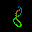

test_digit/8 expected, 8 found with score 0.988281


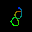

test_digit/8 expected, 8 found with score 0.992188


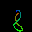

test_digit/8 expected, 8 found with score 0.937500


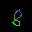

test_digit/8 expected, 8 found with score 0.968750


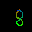

test_digit/8 expected, 8 found with score 0.996094


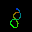

test_digit/8 expected, 8 found with score 0.957031


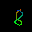

test_digit/8 expected, 8 found with score 0.984375


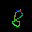

test_digit/8 expected, 8 found with score 0.984375


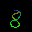

test_digit/8 expected, 8 found with score 0.972656


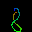

test_digit/8 expected, 8 found with score 0.960938


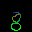

test_digit/8 expected, 8 found with score 0.972656


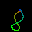

test_digit/8 expected, 8 found with score 0.968750


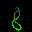

test_digit/8 expected, 8 found with score 0.988281


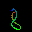

test_digit/8 expected, 8 found with score 0.855469


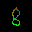

test_digit/8 expected, 8 found with score 0.937500


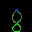

test_digit/8 expected, 8 found with score 0.992188


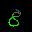

test_digit/8 expected, 8 found with score 0.996094


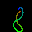

test_digit/8 expected, 8 found with score 0.976562


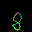

test_digit/8 expected, 8 found with score 0.917969


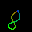

test_digit/8 expected, 8 found with score 0.941406


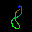

test_digit/8 expected, 8 found with score 0.937500


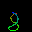

test_digit/8 expected, 8 found with score 0.910156


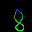

test_digit/8 expected, 8 found with score 0.972656


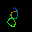

test_digit/8 expected, 8 found with score 0.996094


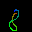

test_digit/8 expected, 8 found with score 0.906250


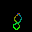

test_digit/8 expected, 8 found with score 0.976562


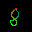

test_digit/8 expected, 8 found with score 0.949219


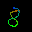

test_digit/8 expected, 8 found with score 0.828125


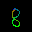

test_digit/8 expected, 8 found with score 0.996094


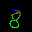

test_digit/8 expected, 8 found with score 0.992188


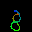

test_digit/8 expected, 8 found with score 0.972656


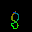

test_digit/8 expected, 8 found with score 0.972656


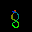

test_digit/8 expected, 8 found with score 0.980469


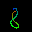

test_digit/8 expected, 8 found with score 0.980469


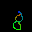

test_digit/8 expected, 8 found with score 0.984375


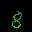

test_digit/8 expected, 8 found with score 0.988281


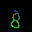

test_digit/8 expected, 8 found with score 0.960938


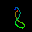

test_digit/8 expected, 8 found with score 0.953125


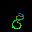

test_digit/8 expected, 8 found with score 0.925781


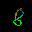

test_digit/8 expected, 8 found with score 0.949219


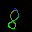

test_digit/8 expected, 8 found with score 0.910156


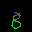

test_digit/8 expected, 8 found with score 0.968750


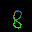

test_digit/8 expected, 8 found with score 0.980469


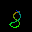

test_digit/8 expected, 8 found with score 0.964844


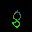

test_digit/8 expected, 8 found with score 0.964844


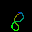

test_digit/8 expected, 8 found with score 0.980469


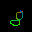

test_digit/8 expected, 8 found with score 0.882812


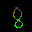

test_digit/8 expected, 8 found with score 0.980469


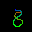

test_digit/8 expected, 8 found with score 0.929688


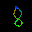

test_digit/8 expected, 8 found with score 0.968750


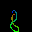

test_digit/8 expected, 8 found with score 0.992188


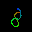

test_digit/8 expected, 8 found with score 0.992188


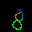

test_alphabet/x expected, 23 found with score 0.972656


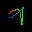

test_alphabet/x expected, 23 found with score 0.945312


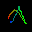

test_alphabet/x expected, 23 found with score 0.929688


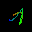

test_alphabet/x expected, 23 found with score 0.757812


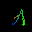

test_alphabet/x expected, 23 found with score 0.957031


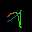

test_alphabet/x expected, 23 found with score 0.824219


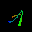

test_alphabet/x expected, 23 found with score 0.765625


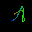

test_alphabet/x expected, 23 found with score 0.964844


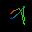

test_alphabet/x expected, 23 found with score 0.968750


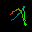

test_alphabet/x expected, 23 found with score 0.984375


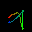

test_alphabet/x expected, 23 found with score 0.929688


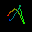

test_alphabet/x expected, 23 found with score 0.898438


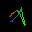

test_alphabet/x expected, 23 found with score 0.816406


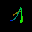

test_alphabet/x expected, 23 found with score 0.882812


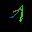

test_alphabet/x expected, 23 found with score 0.917969


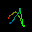

test_alphabet/x expected, 23 found with score 0.781250


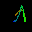

test_alphabet/x expected, 23 found with score 0.960938


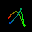

test_alphabet/x expected, 23 found with score 0.968750


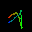

test_alphabet/a expected, 0 found with score 0.835938


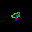

test_alphabet/a expected, 0 found with score 0.796875


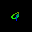

test_alphabet/a expected, 0 found with score 0.800781


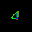

test_alphabet/a expected, 0 found with score 0.875000


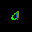

test_alphabet/a expected, 0 found with score 0.835938


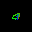

test_alphabet/a expected, 0 found with score 0.812500


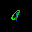

test_alphabet/a expected, 0 found with score 0.757812


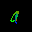

test_alphabet/g expected, 5 found with score 0.886719


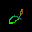

test_alphabet/g expected, 6 found with score 0.914062


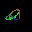

test_alphabet/g expected, 6 found with score 0.937500


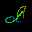

test_alphabet/g expected, 6 found with score 0.949219


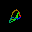

test_alphabet/g expected, 6 found with score 0.832031


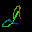

test_alphabet/g expected, 6 found with score 0.968750


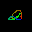

test_alphabet/g expected, 5 found with score 0.781250


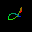

test_alphabet/g expected, 6 found with score 0.929688


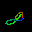

test_alphabet/g expected, 6 found with score 0.957031


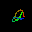

test_alphabet/g expected, 6 found with score 0.976562


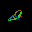

test_alphabet/g expected, 6 found with score 0.843750


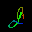

test_alphabet/g expected, 6 found with score 0.753906


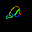

test_alphabet/g expected, 5 found with score 0.910156


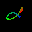

test_alphabet/g expected, 6 found with score 0.898438


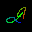

test_alphabet/g expected, 5 found with score 0.812500


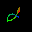

test_alphabet/g expected, 6 found with score 0.863281


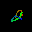

test_alphabet/g expected, 6 found with score 0.988281


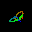

test_alphabet/g expected, 6 found with score 0.968750


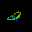

test_alphabet/g expected, 5 found with score 0.812500


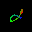

test_alphabet/g expected, 6 found with score 0.972656


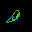

test_alphabet/g expected, 6 found with score 0.757812


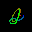

test_alphabet/g expected, 6 found with score 0.890625


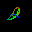

test_alphabet/g expected, 6 found with score 0.839844


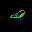

test_alphabet/g expected, 6 found with score 0.757812


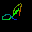

test_alphabet/g expected, 6 found with score 0.929688


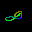

test_alphabet/g expected, 6 found with score 0.980469


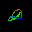

test_alphabet/g expected, 6 found with score 0.898438


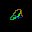

test_alphabet/g expected, 6 found with score 0.902344


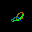

test_alphabet/g expected, 6 found with score 0.902344


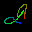

test_alphabet/g expected, 6 found with score 0.816406


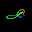

test_alphabet/g expected, 6 found with score 0.972656


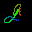

test_alphabet/g expected, 6 found with score 0.960938


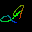

test_alphabet/g expected, 6 found with score 0.765625


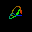

test_alphabet/g expected, 6 found with score 0.875000


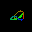

test_alphabet/g expected, 6 found with score 0.855469


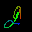

test_alphabet/g expected, 6 found with score 0.921875


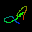

test_alphabet/g expected, 6 found with score 0.785156


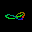

test_alphabet/g expected, 6 found with score 0.957031


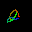

test_alphabet/g expected, 6 found with score 0.863281


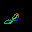

test_alphabet/g expected, 6 found with score 0.781250


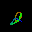

test_alphabet/g expected, 6 found with score 0.953125


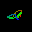

test_alphabet/g expected, 6 found with score 0.871094


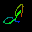

test_alphabet/g expected, 6 found with score 0.949219


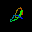

test_alphabet/g expected, 6 found with score 0.769531


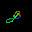

test_alphabet/g expected, 6 found with score 0.964844


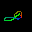

test_alphabet/f expected, 5 found with score 0.816406


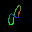

test_alphabet/f expected, 5 found with score 0.757812


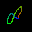

test_alphabet/f expected, 5 found with score 0.816406


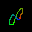

test_alphabet/e expected, 4 found with score 0.753906


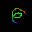

test_alphabet/m expected, 12 found with score 0.808594


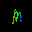

test_alphabet/m expected, 12 found with score 0.773438


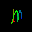

test_alphabet/m expected, 12 found with score 0.800781


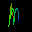

test_alphabet/m expected, 12 found with score 0.753906


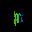

test_alphabet/m expected, 12 found with score 0.789062


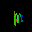

test_alphabet/m expected, 12 found with score 0.781250


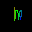

test_alphabet/m expected, 12 found with score 0.765625


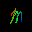

test_alphabet/m expected, 12 found with score 0.757812


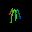

test_alphabet/m expected, 12 found with score 0.898438


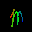

test_alphabet/m expected, 12 found with score 0.769531


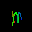

test_alphabet/m expected, 12 found with score 0.750000


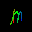

test_alphabet/d expected, 3 found with score 0.816406


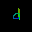

test_alphabet/d expected, 3 found with score 0.804688


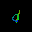

test_alphabet/d expected, 3 found with score 0.761719


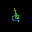

test_alphabet/d expected, 3 found with score 0.882812


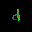

test_alphabet/d expected, 3 found with score 0.781250


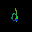

test_alphabet/d expected, 3 found with score 0.781250


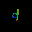

test_alphabet/d expected, 3 found with score 0.859375


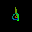

test_alphabet/d expected, 3 found with score 0.871094


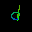

test_alphabet/d expected, 3 found with score 0.773438


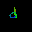

test_alphabet/d expected, 3 found with score 0.796875


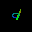

test_alphabet/d expected, 3 found with score 0.808594


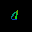

test_alphabet/d expected, 3 found with score 0.808594


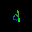

test_alphabet/d expected, 3 found with score 0.855469


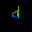

test_alphabet/d expected, 3 found with score 0.917969


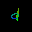

test_alphabet/d expected, 3 found with score 0.773438


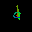

test_alphabet/d expected, 3 found with score 0.753906


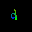

test_alphabet/d expected, 3 found with score 0.824219


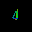

test_alphabet/d expected, 3 found with score 0.785156


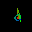

test_alphabet/d expected, 3 found with score 0.828125


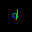

test_alphabet/d expected, 3 found with score 0.789062


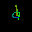

test_alphabet/d expected, 3 found with score 0.839844


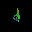

test_alphabet/d expected, 3 found with score 0.761719


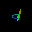

test_alphabet/d expected, 3 found with score 0.894531


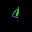

test_alphabet/d expected, 3 found with score 0.882812


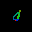

test_alphabet/d expected, 3 found with score 0.835938


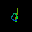

test_alphabet/d expected, 3 found with score 0.773438


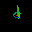

test_alphabet/d expected, 3 found with score 0.835938


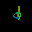

0.0% correct (N=1248, 2305 unknown)


In [53]:
from IPython.display import Image, display

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test*/*"):
  flag = label_dir.split("/")[0].split("_")[-1]
  if flag == "digit":
    model_tflite = model_tflite_digit
  elif flag == "figure":
    model_tflite = model_tflite_figure
  else:
    model_tflite = model_tflite_alphabet
  label = label_dir.replace("test*/", "")
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(model_tflite, filename)
    if score < 0.75:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      print("%s expected, %d found with score %f" % (label, index, score))
      display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

In [54]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_DIGIT_FILENAME} > {TFL_CC_MODEL_DIGIT_FILENAME}
# Update variable names
REPLACE_TEXT_DIGIT = QUANTIZED_TFL_MODEL_DIGIT_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_DIGIT}'/g_magic_wand_model_digit_data/g' {TFL_CC_MODEL_DIGIT_FILENAME}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,383 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/uni

In [55]:
# Print the C source file
!tail {TFL_CC_MODEL_DIGIT_FILENAME}

  0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09,
  0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_digit_data_len = 31424;


In [56]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FIGURE_FILENAME} > {TFL_CC_MODEL_FIGURE_FILENAME}
# Update variable names
REPLACE_TEXT_FIGURE = QUANTIZED_TFL_MODEL_FIGURE_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_FIGURE}'/g_magic_wand_model_figure_data/g' {TFL_CC_MODEL_FIGURE_FILENAME}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 119 kB in 2s (68.5 kB/s)
Reading package lists... Done


In [57]:
# Print the C source file
!tail {TFL_CC_MODEL_FIGURE_FILENAME}

  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_figure_data_len = 30952;


In [58]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_ALPHABET_FILENAME} > {TFL_CC_MODEL_ALPHABET_FILENAME}
# Update variable names
REPLACE_TEXT_ALPHABET = QUANTIZED_TFL_MODEL_ALPHABET_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_ALPHABET}'/g_magic_wand_model_alphabet_data/g' {TFL_CC_MODEL_ALPHABET_FILENAME}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [59]:
# Print the C source file
!tail {TFL_CC_MODEL_ALPHABET_FILENAME}

  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_alphabet_data_len = 32392;
